<a href="https://colab.research.google.com/github/rlagosb/GastricCancerIncidence/blob/main/2_Methods_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción
Este notebook contiene el código y los análisis para la estimación de la incidencia de cáncer gástrico en las provincias de Chile entre 2003 y 2024. Incluye la carga de datos, la calibración de ratios utilizando modelos lineales mixtos, la proyección de incidencias, y la evaluación de los modelos mediante validación interna y externa (comparación con datos de IARC). Se exploran diferentes métodos y covariables para mejorar la precisión de las estimaciones.

# Setup 💾

In [1]:
# Cargar librerías
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.formula.api as smf   # https://www.statsmodels.org/dev/generated/statsmodels.formula.api.mixedlm.html
import statsmodels.api as sm            # https://www.statsmodels.org/dev/examples/notebooks/generated/mixed_lm_example.html
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, t, skewnorm, kstest
import seaborn as sns
from sklearn.metrics import r2_score
import time
import os

# Carpetas de origen y destino
path_data='https://raw.githubusercontent.com/rlagosb/GastricCancerIncidence/main/Data/'
path_output = '/content/output/'
# Crear carpeta output
if not os.path.exists(path_output): os.makedirs(path_output)

# Fuentes de datos
predicciones_file = 'Predicciones.parquet'

# Nro de habitantes para calcular tasas
HABS = 100000

In [103]:
# @title Cargar datos
cubo = pd.read_parquet(path_data + 'CUBO_CANCER_DIGESTIVO.parquet')

print(cubo.info())
cubo.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22176 entries, 0 to 22175
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Provincia             22176 non-null  int64  
 1   Nombre Provincia      22176 non-null  object 
 2   Nombre Region         22176 non-null  object 
 3   Region                22176 non-null  int64  
 4   Año                   22176 non-null  int64  
 5   Codigo                22176 non-null  int64  
 6   Sexo                  22176 non-null  object 
 7   RangoEdad10           22176 non-null  object 
 8   RangoEdad4080         22176 non-null  object 
 9   MedianaRangoEdad10    22176 non-null  float64
 10  MedianaRangoEdad4080  22176 non-null  float64
 11  Poblacion             22176 non-null  int64  
 12  PoblacionRural        22176 non-null  int64  
 13  A                     22176 non-null  int64  
 14  B                     22176 non-null  int64  
 15  C                  

,Provincia,Nombre Provincia,Nombre Region,Region,Año,Codigo,Sexo,RangoEdad10,RangoEdad4080,MedianaRangoEdad10,...,D,Fonasa,Isapre,Categoria,Cancer,RPC,Casos,Defunciones,EgresosDefs,Egresos2
9355,103,Osorno,Los Lagos,10,2008,1,Hombre,"[70, 80)","[70, 80)",75.0,...,947,40829,0,C16,C16 Tumor maligno del estómago,0,0,12,16,9
1486,51,Valparaíso,Valparaíso,5,2015,1,Hombre,"[10, 20)","[0, 40)",15.0,...,12297,27295,8257,C16,C16 Tumor maligno del estómago,0,0,0,0,0
20161,62,Cardenal Caro,Libertador General Bernardo O'Higgins,6,2012,2,Mujer,"[70, 80)","[70, 80)",75.0,...,96,3557,9,C16,C16 Tumor maligno del estómago,0,0,0,0,0


In [107]:
# Escenarios = conjuntos de training y testing
escenarios_xl = pd.read_excel(path_data + 'Parametros_estimaciones.xlsx', sheet_name='Escenarios')

# Agrupación de años en periodos
periodos_xl = pd.read_excel(path_data + 'Parametros_estimaciones.xlsx', sheet_name='Periodos RPC', header=1)

def cargar_periodos_rpc(df):
  df = (df.rename(columns={'ID':'Año'}).
        melt(id_vars='Año', value_name='Periodo', var_name='Provincia').
        dropna(subset='Periodo'))
  for col in df.columns: df[col] = df[col].astype(int)
  return df
periodos = cargar_periodos_rpc(periodos_xl)


Datos de Incidencia IARC obtenidos de *Cancer Over time*:

- [Incidencia por sexo](https://gco.iarc.fr/overtime/en/dataviz/trends?populations=152&sexes=1_2&types=0&multiple_populations=1&cancers=3)
- [Incidencia ambos sexos](https://gco.iarc.fr/overtime/en/dataviz/trends?populations=152&sexes=0&types=0&multiple_populations=1&cancers=3)
- [Incidencia 2022](https://gco.iarc.fr/today/en/dataviz/maps-heatmap?mode=population&cancers=7&types=0&zoom=2)

Población OMS: https://seer.cancer.gov/stdpopulations/world.who.html

In [ ]:
def cargar_incidencia_IARC():

  df = (pd.read_excel(path_data + 'Parametros_estimaciones.xlsx', sheet_name='IARC_dataset_asr_inc_stomach', usecols='B:I').
        rename(columns={'Year': 'Año',
                        'ASR (World)': 'IncidenciaIARC',
                        'Crude rate': 'IncidenciaCruda'}).
        merge(periodos[periodos.Provincia==1000][['Año','Periodo']], on='Año'))
  df['Sexo'] = df.Sex.map({1:'Hombre', 2:'Mujer',0:'Ambos'})

  # Agregar incidencia std 2022:  21.8 hombres, 8.0 mujeres, 14.2 ambos
  # incidencia cruda 2022:        35.3 hombres, 16.5 mujeres, 25.7 ambos
  incidencia2022 = pd.DataFrame([{'Año':2022,'Periodo':2023,'Sexo':'Hombre','IncidenciaIARC':21.8,'IncidenciaCruda':35.3,'Cancer label':'Stomach','Country label':'Chile'},
                                 {'Año':2022,'Periodo':2023,'Sexo':'Mujer','IncidenciaIARC':8.0,'IncidenciaCruda':16.5,'Cancer label':'Stomach','Country label':'Chile'},
                                 {'Año':2022,'Periodo':2023,'Sexo':'Ambos','IncidenciaIARC':14.2,'IncidenciaCruda':25.7,'Cancer label':'Stomach','Country label':'Chile'}])
  df = pd.concat([df,incidencia2022]).reset_index(drop=True)

  return df

incidenciaIARC = cargar_incidencia_IARC()

def cargar_poblacion_estandar(RangoEdad='RangoEdad4080'):

  df = (pd.read_excel(path_data + 'Parametros_estimaciones.xlsx', sheet_name='Poblacion_OMS').drop(columns=['Age']).
        pivot_table(index=[RangoEdad], values='PoblacionOMS', aggfunc='sum', margins=True).reset_index())
  return df

poblacion_estandar = cargar_poblacion_estandar()
print(poblacion_estandar)

  RangoEdad4080  PoblacionOMS
0       [0, 40)        655070
1      [40, 50)        126256
2      [50, 60)         99165
3      [60, 70)         66777
4      [70, 80)         37287
5     [80, 120)         15445
6           All       1000000


In [4]:
## Cargar escenarios de training/testing para la cross-validation

# @title Cargar Escenarios
def cargar_escenarios(xls_escenarios):

  escenarios = pd.DataFrame()
  for index, row in xls_escenarios.iterrows():

    # Generar dataframes de provincias
    training_provs_array = row['Provincias training'].split(',')
    testing_provs_array = row['Provincias testing'].split(',') if ',' in str(row['Provincias testing']) else [row['Provincias testing']]
    provincias_train = pd.DataFrame({'Provincia': training_provs_array,'Grupo':'Training'})
    provincia_test = pd.DataFrame({'Provincia': testing_provs_array, 'Grupo':'Testing'})
    # Convert 'Provincia' to integer type
    provincias_train['Provincia'] = provincias_train['Provincia'].astype(int)
    provincia_test['Provincia'] = provincia_test['Provincia'].astype(int)

    # Dataframes de periodos
    period_train = row['Periodo training'][1:-1].split(',')
    period_test = row['Periodo testing'][1:-1].split(',')
    df_train = pd.DataFrame({'Año': range(int(period_train[0]), int(period_train[1]) + 1)})
    df_test = pd.DataFrame({'Año': range(int(period_test[0]), int(period_test[1]) + 1)})

    # Combinar provincias y periodos
    df_test = df_test.merge(provincia_test, how='cross')
    df_train = df_train.merge(provincias_train, how='cross')

    # Agregar grupos de años
    df_train = df_train.merge(periodos, on=['Año','Provincia'])
    if row['Escenario'] != 'Chile':
      df_test = df_test.merge(periodos, on=['Año','Provincia'])
    else:
      periodosChile = periodos[periodos.Provincia==1000][['Año','Periodo']]
      df_test = df_test.merge(periodosChile, on='Año')

    # Metadatos Escenario
    escenario_new = pd.concat([df_train, df_test])
    for col in ['Escenario','Tipo']: escenario_new[col] = row[col]

    # Juntar con dataframe pruebas
    escenarios = pd.concat([escenarios, escenario_new])

  escenarios[['Año','Provincia']] = escenarios[['Año','Provincia']].astype(int)
  return escenarios

escenarios = cargar_escenarios(escenarios_xl)
print(escenarios.info())
print(escenarios[['Tipo','Escenario']].value_counts())
escenarios.sample(3)

<class 'pandas.core.frame.DataFrame'>
Index: 2860 entries, 0 to 1209
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Año        2860 non-null   int64 
 1   Provincia  2860 non-null   int64 
 2   Grupo      2860 non-null   object
 3   Periodo    2860 non-null   int64 
 4   Escenario  2860 non-null   object
 5   Tipo       2860 non-null   object
dtypes: int64(3), object(3)
memory usage: 156.4+ KB
None
Tipo        Escenario   
Proyeccion  Chile           1320
Evaluacion  Escenario1       220
            Escenario142     110
            Escenario151     110
            Escenario21      110
            Escenario141     110
            Escenario22      110
            Escenario23      110
            Escenario72      110
            Escenario71      110
            Escenario73      110
            Escenario74      110
            Escenario81      110
            Escenario83      110
Name: count, dtype: int64


,Año,Provincia,Grupo,Periodo,Escenario,Tipo
118,2005,51,Testing,2004,Chile,Proyeccion
45,2009,141,Training,2010,Escenario73,Evaluacion
635,2014,123,Testing,2014,Chile,Proyeccion


# 🧰 Funciones

## 🌅 Calcular Ratios del Escenario

⚠ `Poblacion` equivale a los Años-personas del periodo

In [15]:
# @title Calcular métricas provincias

def calcular_metricas_provincias(cubo, HABS, RangoEdad) -> pd.DataFrame:

    # Agrupar cubo en RangoEdad seleccionado
    rangos = [col for col in cubo.columns if 'RangoEdad' in col and RangoEdad not in col]
    metricas = (['Poblacion','PoblacionRural','Casos','Defunciones','EgresosDefs','Egresos2']
                + ['Fonasa','A','B','C','D','Isapre'])
    group_columns = ['Sexo',RangoEdad,'Mediana'+RangoEdad,'Periodo','Provincia','Nombre Provincia','Categoria',
                     'Grupo','Escenario','Tipo']
    # Create an aggregation dictionary: sum for metrics_to_aggregate, max for RPC
    agg_functions = {col: 'sum' for col in metricas}
    agg_functions['RPC'] = 'max'
    df = cubo.groupby(group_columns, dropna=False).agg(agg_functions).reset_index()

    # Calcular covariables
    df['Ruralidad'] = df['PoblacionRural'] / df['Poblacion']
    for tramo in ['A','B','C','D','Fonasa','Isapre']:
      df['Porc'+tramo] = df[tramo] / df['Poblacion']

    # Calcular métricas: tasas y Ratios, etc
    for key, value in {'IncidenciaObs':'Casos','MortalidadObs':'Defunciones','TasaDefHosp2Obs':'EgresosDefs','TasaHosp2Obs':'Egresos2'}.items():
      df[key] = df[value] / df['Poblacion'] * HABS
    for key, value in {'RIMobs':'Defunciones','RIMHobs':'EgresosDefs','RIHobs':'Egresos2'}.items():
      df[key] = df[value] / df['Casos']

    # Dejar sólo valores de RPCs y ratios para casos>0
    df.loc[df.RPC==0, 'IncidenciaObs'] = None
    for col in ['RIMobs','RIHobs','RIMHobs','RIH2obs']:
      df.loc[df.RPC*df.Casos==0, col] = None

    return df

def cargar_datos_escenario(escenario, RangoEdad, categoria='C16', **kwargs):

  # Cargar provincias del escenario
  provs = escenarios[escenarios.Escenario==escenario].copy()
  # Cargar datos cubo y cruzar con escenario
  data = (cubo[cubo.Categoria==categoria].
          merge(provs, on=['Provincia','Año'], how='inner'))
  data = (calcular_metricas_provincias(data, HABS, RangoEdad))

  # Filtrar observaciones según tipo de escenario
  evaluacion = (data.Tipo.iloc[0]=='Evaluacion')
  print(f'Cargando {escenario} ', '(evaluacion)' if evaluacion else '(proyección)')
  if not evaluacion:
    data = data[(data.RPC>0) | (data.Grupo=='Testing')]
  else:
    data = data[data.RPC>0]

  print('Training: ', data[data.Grupo=='Training'].Periodo.min(),'-', data[data.Grupo=='Training'].Periodo.max(), data[data.Grupo=='Training'].Provincia.unique(), ' N=',len(data[data.Grupo=='Training']))
  print('Testing: ', data[data.Grupo=='Testing'].Periodo.min(),'-', data[data.Grupo=='Testing'].Periodo.max(), data[data.Grupo=='Testing'].Provincia.unique(), ' N=',len(data[data.Grupo=='Testing']))
  return data

dataEj = cargar_datos_escenario('Escenario1', 'RangoEdad4080')
print(dataEj.groupby('Grupo')['Casos'].agg(['count','sum']))
dataEj

Cargando Escenario1  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73  74]  N= 420
Testing:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73  74]  N= 420
          count   sum
Grupo                
Testing     420  7224
Training    420  7224


,Sexo,RangoEdad4080,MedianaRangoEdad4080,Periodo,Provincia,Nombre Provincia,Categoria,Grupo,Escenario,Tipo,...,PorcFonasa,PorcIsapre,IncidenciaObs,MortalidadObs,TasaDefHosp2Obs,TasaHosp2Obs,RIMobs,RIMHobs,RIHobs,RIH2obs
0,Hombre,"[0, 40)",20.0,2004,83,Bíobío,C16,Testing,Escenario1,Evaluacion,...,0.194435,0.129641,1.365590,0.819354,1.911827,1.365590,0.600000,1.400000,1.000000,NaN
1,Hombre,"[0, 40)",20.0,2004,83,Bíobío,C16,Training,Escenario1,Evaluacion,...,0.194435,0.129641,1.365590,0.819354,1.911827,1.365590,0.600000,1.400000,1.000000,NaN
2,Hombre,"[0, 40)",20.0,2004,141,Valdivia,C16,Testing,Escenario1,Evaluacion,...,0.405395,0.172396,2.216320,0.369387,1.846934,1.846934,0.166667,0.833333,0.833333,NaN
3,Hombre,"[0, 40)",20.0,2004,141,Valdivia,C16,Training,Escenario1,Evaluacion,...,0.405395,0.172396,2.216320,0.369387,1.846934,1.846934,0.166667,0.833333,0.833333,NaN
4,Hombre,"[0, 40)",20.0,2004,142,Ranco,C16,Testing,Escenario1,Evaluacion,...,0.501658,0.042958,1.055989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,Mujer,"[80, 120)",90.0,2018,72,Cauquenes,C16,Training,Escenario1,Evaluacion,...,0.851582,0.010026,98.289758,137.605661,117.947710,19.657952,1.400000,1.200000,0.200000,NaN
836,Mujer,"[80, 120)",90.0,2018,73,Curicó,C16,Testing,Escenario1,Evaluacion,...,0.538107,0.021660,101.529714,162.447543,162.447543,33.843238,1.600000,1.600000,0.333333,NaN
837,Mujer,"[80, 120)",90.0,2018,73,Curicó,C16,Training,Escenario1,Evaluacion,...,0.538107,0.021660,101.529714,162.447543,162.447543,33.843238,1.600000,1.600000,0.333333,NaN
838,Mujer,"[80, 120)",90.0,2018,74,Linares,C16,Testing,Escenario1,Evaluacion,...,0.826447,0.017108,111.172874,166.759311,166.759311,49.410166,1.500000,1.500000,0.444444,NaN


In [7]:
# @title Calibrar Ratios

def regresion_ratios(data, RangoEdad, Ratio, summary=False, covariables=None, gruposRegresion='Provincia', **kwargs):

  # Transformación Logaritmo
  okRatios = (data[Ratio + 'obs']!=0)
  data.loc[okRatios, 'Log' + Ratio] = np.log(data[okRatios][Ratio + 'obs'])

  # Fórmula del modelo
  Y = 'Log' + Ratio
  formula = (Y + ' ~ Mediana' + RangoEdad)
  if covariables is not None:
    for cov in covariables: formula += (' + ' + cov)
  print('Modelo: ', formula)
  # Efectos aleatorios
  reFormula = ("~ 1 + Periodo"  if 'rePeriodo' in kwargs else "~ 1")
  #if 'rePeriodo' in kwargs: data = data[data.RPC<6]

  # Datos de entrenamiento
  training_data = data[(data.Grupo=='Training')&(data[Y].notna())].copy()
  print(len(training_data), 'observaciones para entrenamiento, ',
        len(data[(data.Grupo=='Training')&(data[Y].isna())][Y].isna()), ' ratios nulos o cero')

  # Ajustar modelo
  md = smf.mixedlm(formula, training_data, groups=gruposRegresion, re_formula=reFormula)
  model = md.fit(maxiter=5000)
  data['GroupVar'] = model.params[gruposRegresion+' Var']
  data['ModelConverged'] = model.converged
  data['LogLikelihood'] = model.llf
  data['ModelScale'] = model.scale  #varianza residuos

  if summary: print(model.summary())
  else: print('✔' if (model.converged and not np.isinf(model.llf)) else '❌ NO',f'convergió modelo, Log-Likelihood = {model.llf}')

  # Generar predicciones LogRatio
  data[Y+'est'] = model.predict(data)

  return data


dataReg = regresion_ratios(dataEj.copy(),
                           RangoEdad = 'RangoEdad4080',
                           Ratio = 'RIM', covariables=None,
                           summary=True)

Modelo:  LogRIM ~ MedianaRangoEdad4080
363 observaciones para entrenamiento,  57  ratios nulos o cero
             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    LogRIM   
No. Observations:    363        Method:                REML     
No. Groups:          12         Scale:                 0.1449   
Min. group size:     7          Log-Likelihood:        -174.6766
Max. group size:     58         Converged:             Yes      
Mean group size:     30.2                                       
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept            -0.745    0.065 -11.491 0.000 -0.872 -0.618
MedianaRangoEdad4080  0.008    0.001   8.390 0.000  0.006  0.010
Provincia Var         0.003    0.008                            



/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## 📈 Estimar incidencia

In [9]:
def proyectar_incidencia(data, Ratio, **kwargs):

  # Revertir transformación Ratio
  data['Ratio'] = Ratio
  data['RatioEst'] = np.exp(data['Log' + Ratio + 'est'])

  # Incidencia estimada = métrica / Ratio
  metrica = {'RIM':'MortalidadObs','RIMH':'TasaDefHosp2Obs','RIH':'TasaHosp2Obs','RIH2':'TasaHospObs'}
  data['IncidenciaEst'] = 0.0
  okProy = ((data.Grupo=='Testing') &                                   # proyectar sólo en periodos-provincias de testing
            data['RatioEst'].notna() & data[metrica[Ratio]].notna())    # proyectar sólo si hay ratio y métrica disponible
  data.loc[okProy, 'IncidenciaEst'] = data[okProy][metrica[Ratio]] / data[okProy]['RatioEst']

  return data

dataInc = proyectar_incidencia(dataReg.copy(), Ratio = 'RIM', transformation = 'Log')
dataInc

,Sexo,RangoEdad4080,MedianaRangoEdad4080,Periodo,Provincia,Nombre Provincia,Categoria,Grupo,Escenario,Tipo,...,RIH2obs,LogRIM,GroupVar,ModelConverged,LogLikelihood,ModelScale,LogRIMest,Ratio,RatioEst,IncidenciaEst
0,Hombre,"[0, 40)",20.0,2004,83,Bíobío,C16,Testing,Escenario1,Evaluacion,...,NaN,-0.510826,0.018076,True,-174.676613,0.144853,-0.584599,RIM,0.557329,1.470144
1,Hombre,"[0, 40)",20.0,2004,83,Bíobío,C16,Training,Escenario1,Evaluacion,...,NaN,-0.510826,0.018076,True,-174.676613,0.144853,-0.584599,RIM,0.557329,0.000000
2,Hombre,"[0, 40)",20.0,2004,141,Valdivia,C16,Testing,Escenario1,Evaluacion,...,NaN,-1.791759,0.018076,True,-174.676613,0.144853,-0.584599,RIM,0.557329,0.662780
3,Hombre,"[0, 40)",20.0,2004,141,Valdivia,C16,Training,Escenario1,Evaluacion,...,NaN,-1.791759,0.018076,True,-174.676613,0.144853,-0.584599,RIM,0.557329,0.000000
4,Hombre,"[0, 40)",20.0,2004,142,Ranco,C16,Testing,Escenario1,Evaluacion,...,NaN,NaN,0.018076,True,-174.676613,0.144853,-0.584599,RIM,0.557329,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,Mujer,"[80, 120)",90.0,2018,72,Cauquenes,C16,Training,Escenario1,Evaluacion,...,NaN,0.336472,0.018076,True,-174.676613,0.144853,-0.023209,RIM,0.977058,0.000000
836,Mujer,"[80, 120)",90.0,2018,73,Curicó,C16,Testing,Escenario1,Evaluacion,...,NaN,0.470004,0.018076,True,-174.676613,0.144853,-0.023209,RIM,0.977058,166.261921
837,Mujer,"[80, 120)",90.0,2018,73,Curicó,C16,Training,Escenario1,Evaluacion,...,NaN,0.470004,0.018076,True,-174.676613,0.144853,-0.023209,RIM,0.977058,0.000000
838,Mujer,"[80, 120)",90.0,2018,74,Linares,C16,Testing,Escenario1,Evaluacion,...,NaN,0.405465,0.018076,True,-174.676613,0.144853,-0.023209,RIM,0.977058,170.674931


In [10]:
def plot_incidencia_proyectada(data, **kwargs):

  df = data[(data.RPC>0)&(data.Grupo=='Testing')].copy()

  # Estimar Casos por estrato
  df['CasosEst'] = df.IncidenciaEst * df.Poblacion / HABS
  df['CasosObs'] = df.IncidenciaObs * df.Poblacion / HABS
  # Calcular incidencia anual de Provincias
  df = df.groupby(['Nombre Provincia','Periodo','RPC'],dropna=False)[['CasosObs', 'CasosEst','Poblacion']].sum().reset_index()
  df['IncidenciaObs'] = df['CasosObs'] / df['Poblacion'] * HABS
  df['IncidenciaEst'] = df['CasosEst'] / df['Poblacion'] * HABS

  # Melt the dataframe to long format for plotting
  df_melted = df.melt(id_vars=['Nombre Provincia', 'Periodo', 'RPC'],
                      value_vars=['IncidenciaObs', 'IncidenciaEst'],
                      var_name='Type', value_name='Incidencia')

  # Create the scatter plot with different modes
  fig = px.scatter(df_melted,
                    y='Incidencia', x='Periodo',
                    color='Type', color_discrete_sequence=['blue', 'red'],
                    facet_col='Nombre Provincia', facet_col_wrap=4)

  # Update traces to show 'IncidenciaEst' as lines and 'IncidenciaObs' as dots
  fig.update_traces(mode='lines+markers', selector=dict(name='IncidenciaEst'))
  fig.update_traces(mode='markers', selector=dict(name='IncidenciaObs'))
  fig.update_traces(marker_size=3, selector=dict(name='IncidenciaObs'))
  fig.update_traces(line_width=1.5, selector=dict(name='IncidenciaEst'))
  fig.update_traces(marker_size=2, selector=dict(name='IncidenciaEst'))
  fig.for_each_annotation( lambda  a :  a.update( text = a.text.split( "=" )[ - 1 ]))
  fig.update_xaxes(title_text='')
  fig.update_yaxes(title_text='')
  fig.show()

  df =  df[df[['IncidenciaEst','IncidenciaObs']].notna().all(axis=1)]
  print('R2 incidencia: ', r2_score(df['IncidenciaObs'], df['IncidenciaEst']))

plot_incidencia_proyectada(dataInc)

R2 incidencia:  0.8919279292423112


## 💾 Guardar / eliminar estimaciones

In [12]:
# Guardar proyecciones del grupo de testing

def guardar_proyecciones(data, RangoEdad, nombreMetodo, **kwargs):

  columnas= ([RangoEdad] + ['Nombre Provincia','Provincia', 'Sexo', 'Periodo', 'Categoria'] +
             ['Ratio','RatioEst','IncidenciaObs', 'IncidenciaEst','Poblacion'] +
             ['Metodo','Escenario', 'Grupo'])
  data['Metodo'] = nombreMetodo

  # REEMPLAZAR predicciones anteriores con mismo Metodo y escenario
  try:
    anteriores = pd.read_parquet(path_output + predicciones_file)
    reemplazar = ((anteriores.Metodo==nombreMetodo) & (anteriores.Escenario==data.Escenario.iloc[0]))
    anteriores = anteriores[~reemplazar]
    predicciones =  pd.concat([anteriores, data[data.Grupo=='Testing'][columnas]])  # guarda sólo proyecciones del grupo de testing
  except:
    predicciones = data[data.Grupo=='Testing'][columnas].copy()                     # idem

  predicciones.to_parquet(path_output + predicciones_file)
  print(predicciones[(predicciones.Metodo==nombreMetodo)&(predicciones.Escenario==data.Escenario.iloc[0])].shape[0],
        ' predicciones guardadas\n---')

def remove_metodo(nombreMetodo):
  df = pd.read_parquet(path_output + predicciones_file)
  n = df[df.Metodo==nombreMetodo].shape[0]
  df = df[df.Metodo != nombreMetodo]
  print(n, f' predicciones previas de {nombreMetodo} eliminadas\n')
  df.to_parquet(path_output + predicciones_file)
  return df.Metodo.unique() #df[['Metodo','Ratio','Escenario']].value_counts(dropna=False,sort=False)

guardar_proyecciones(dataInc, 'RangoEdad4080', nombreMetodo='Ejemplo')
remove_metodo('EJE')

420  predicciones guardadas
---
0  predicciones previas de EJE eliminadas



array(['Ejemplo'], dtype=object)

## 🚨 Errores
Métricas de error en el periodo de prueba de $T$ años:

- $Bias_{rsa} = \frac{\sum{ (IncidenciaEst_{rsat} - IncidenciaObs_{rsat})}}{T}$

- $Mean Squared Error_{rsa} = \frac{\sum{(IncidenciaEst_{rsat} - IncidenciaObs_{rsat})^2}}{T}$

- $Mean Percentual Error_{rsa} = \frac{\sum{(IncidenciaEst_{rsat} - IncidenciaObs_{rsat})^2}}{IncidenciaEst_{rsat}}$

- $R^2 = 1 - \frac{\sum{(IncidenciaEst_{rsat} - IncidenciaObs_{rsat})^2}}{\sum{(\overline{IncidenciaObs} - IncidenciaObs_{rsat})^2}}$


In [13]:
#@title Calcular Errores

def calcular_errores(metodo=None): # a nivel de provincia

  # Cargar Predicciones
  df = pd.read_parquet(path_output + predicciones_file)
  if metodo is not None: df = df[df.Metodo==metodo]

  # Estimar Casos por estrato
  df['CasosObs'] = df['IncidenciaObs'] * df['Poblacion'] / HABS
  df['CasosEst'] = df['IncidenciaEst'] * df['Poblacion'] / HABS

  # Calcular incidencia anual de Provincias
  df = df.groupby(['Nombre Provincia','Provincia','Periodo','Categoria','Escenario','Grupo','Metodo','Ratio'],
                  dropna=False)[['CasosObs','CasosEst','Poblacion']].sum().reset_index()
  df['IncidenciaObs'] = df['CasosObs'] / df['Poblacion'] * HABS
  df['IncidenciaEst'] = df['CasosEst'] / df['Poblacion'] * HABS

  # Calcular errores
  df['Error'] = df['IncidenciaObs'] - df['IncidenciaEst']
  df['Error2'] = df['Error']**2
  df['ErrorPerc'] = abs(df['Error']) / df['IncidenciaObs']
  df.loc[df['IncidenciaObs']==0,'ErrorPerc'] = None

  return df

errores = calcular_errores(metodo='Ejemplo')
errores

,Nombre Provincia,Provincia,Periodo,Categoria,Escenario,Grupo,Metodo,Ratio,CasosObs,CasosEst,Poblacion,IncidenciaObs,IncidenciaEst,Error,Error2,ErrorPerc
0,Antofagasta,21,2005,C16,Escenario1,Testing,Ejemplo,RIM,204.0,210.477236,1336600,15.262607,15.747212,-0.484605,0.234842,0.031751
1,Antofagasta,21,2008,C16,Escenario1,Testing,Ejemplo,RIM,161.0,153.464525,1059865,15.190614,14.479630,0.710984,0.505499,0.046804
2,Antofagasta,21,2011,C16,Escenario1,Testing,Ejemplo,RIM,157.0,151.346394,1110991,14.131528,13.622648,0.508880,0.258958,0.036010
3,Antofagasta,21,2014,C16,Escenario1,Testing,Ejemplo,RIM,181.0,173.055985,1166630,15.514773,14.833836,0.680937,0.463675,0.043890
4,Arica,151,2010,C16,Escenario1,Testing,Ejemplo,RIM,122.0,115.946409,843007,14.472003,13.753908,0.718095,0.515660,0.049620
5,Arica,151,2013,C16,Escenario1,Testing,Ejemplo,RIM,97.0,99.323564,665733,14.570406,14.919429,-0.349023,0.121817,0.023954
6,Arica,151,2017,C16,Escenario1,Testing,Ejemplo,RIM,143.0,126.095553,930998,15.359861,13.544127,1.815734,3.296890,0.118213
7,Bíobío,83,2004,C16,Escenario1,Testing,Ejemplo,RIM,366.0,363.192733,1126724,32.483554,32.234401,0.249153,0.062077,0.007670
8,Bíobío,83,2007,C16,Escenario1,Testing,Ejemplo,RIM,397.0,367.302619,1157638,34.293968,31.728625,2.565343,6.580983,0.074804
9,Bíobío,83,2010,C16,Escenario1,Testing,Ejemplo,RIM,459.0,464.835451,1187602,38.649312,39.140676,-0.491364,0.241439,0.012713


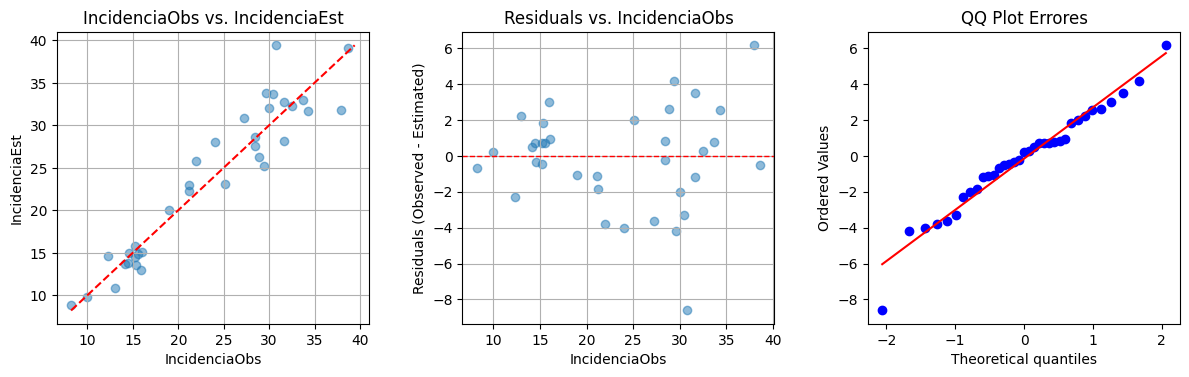

In [14]:
# @title QQ plot (escenario 1)

def plot_error_provincia_anual(errores, metodo):

  # Filtrar errores del método en ESCENARIO 1
  errores_cleaned = errores[(errores.Metodo==metodo)&(errores.Grupo=='Testing')&(errores.Escenario=='Escenario1')].copy()

  # Create a figure and a set of subplots
  fig, axes = plt.subplots(1, 3, figsize=(12, 5)) # 1 row, 3 columns

  # plot IncidenciaObs (x axis) vs IncidenciaEst (y axis) with line y=x
  axes[0].scatter(errores_cleaned['IncidenciaObs'], errores_cleaned['IncidenciaEst'], alpha=0.5)
  axes[0].set_title('IncidenciaObs vs. IncidenciaEst')
  axes[0].set_xlabel('IncidenciaObs')
  axes[0].set_ylabel('IncidenciaEst')
  axes[0].grid(True)
  # Add y = x line
  min_val = min(errores_cleaned['IncidenciaObs'].min(), errores_cleaned['IncidenciaEst'].min())
  max_val = max(errores_cleaned['IncidenciaObs'].max(), errores_cleaned['IncidenciaEst'].max())
  axes[0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

  # Plot residuals (errors)
  axes[1].scatter(errores_cleaned['IncidenciaObs'], errores_cleaned['Error'], alpha=0.5)
  axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
  axes[1].set_title('Residuals vs. IncidenciaObs')
  axes[1].set_xlabel('IncidenciaObs')
  axes[1].set_ylabel('Residuals (Observed - Estimated)')
  axes[1].grid(True)

  # QQ plot
  stats.probplot(errores_cleaned['Error'], dist="norm", plot=axes[2])
  axes[2].set_title('QQ Plot Errores')

  # Adjust layout to prevent titles and labels from overlapping and a small size
  plt.tight_layout()
  plt.subplots_adjust(top=0.7, wspace=0.3)
  plt.show()

plot_error_provincia_anual(errores, 'Ejemplo')

Normal distribution fit: mu = -0.164, std = 2.772
Normal distribution S-W test: statistic = 0.971, p-value = 0.459
Normal distribution K-S test: statistic = 0.098, p-value = 0.854


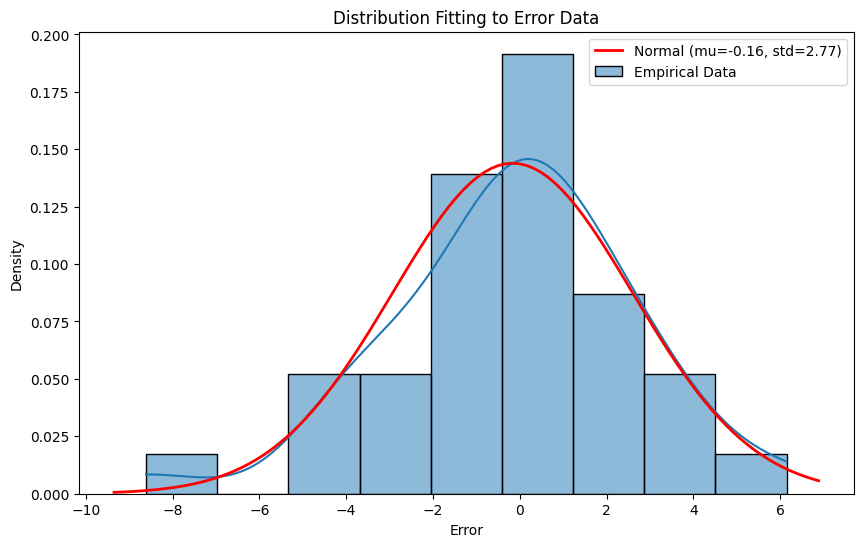


95% Confidence Interval for fitted normal distribution: (np.float64(-5.597977996741023), np.float64(5.269579048913525))


In [22]:
from scipy.stats import shapiro, mannwhitneyu

def analyze_error_distribution(errores, metodo):

  errores_cleaned = errores[(errores.Metodo==metodo)&(errores.Grupo=='Testing')&(errores.Escenario=='Escenario1')].copy()
  data = errores_cleaned['Error']

  # Fit Normal distribution
  mu, std = norm.fit(data)
  print(f"Normal distribution fit: mu = {mu:.3f}, std = {std:.3f}")
  # Perform Shapiro-Wilk test for normality
  stat_shapiro, p_value_shapiro = shapiro(data)
  print(f'Normal distribution S-W test: statistic = {stat_shapiro:.3f}, p-value = {p_value_shapiro:.3f}')
  ks_stat_norm, ks_pvalue_norm = kstest(data, 'norm', args=(mu, std))
  print(f"Normal distribution K-S test: statistic = {ks_stat_norm.item():.3f}, p-value = {ks_pvalue_norm.item():.3f}")


  # Visualize the fitted distributions
  plt.figure(figsize=(10, 6))
  sns.histplot(data, kde=True, stat="density", label="Empirical Data")
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p_norm = norm.pdf(x, mu, std)
  plt.plot(x, p_norm, 'r', linewidth=2, label=f'Normal (mu={mu:.2f}, std={std:.2f})')
  plt.title("Distribution Fitting to Error Data")
  plt.xlabel("Error")
  plt.ylabel("Density")
  plt.legend()
  plt.show()

  # Calculate 95% confidence interval for the fitted normal distribution
  ci_lower, ci_upper = norm.interval(0.95, loc=mu, scale=std)

  return (ci_lower, ci_upper)

t_ci = analyze_error_distribution(errores, 'Ejemplo')
print(f"\n95% Confidence Interval for fitted normal distribution: {t_ci}")

Since this p-value (0.459) is greater than the typical significance level of 0.05, we fail to reject the null hypothesis. This means that, based on the Shapiro-Wilk test, there is not enough statistical evidence to conclude that the 'Error' data is not normally distributed.

In [23]:
# @title Resumen Errores

def resumen_errores(errores, metodos=None):

  # Filtrar datos de errores
  df = errores.copy()
  if metodos is not None: df = df[df.Metodo.isin(metodos)]

  # Nombres evaluaciones
  df['Evaluación'] = 'Cruzada'
  df.loc[df.Escenario=='Escenario1','Evaluación'] = 'RPCs'

  # Métricas de error
  df1 = df.groupby(['Evaluación','Metodo']).agg({'Provincia':'count','IncidenciaObs':'mean','IncidenciaEst':'mean','Error':'mean','Error2':'mean','ErrorPerc':'mean'})
  df1 = df1.set_axis(['N','IncObs','IncEst','Bias', 'RMSE', 'MAPE'], axis=1)
  df1['RMSE'] = np.sqrt(df1['RMSE'])
  df1['MAPE']=df1['MAPE']*100
  df1 = df1.round(2)

  # Calculate R-squared for each group
  df2 = (df.groupby(['Evaluación', 'Metodo'])[['IncidenciaObs','IncidenciaEst']].
         apply(lambda x: r2_score(x.IncidenciaObs, x.IncidenciaEst)).round(4).
         reset_index(name='R2'))

  return df1.join(df2.set_index(['Evaluación','Metodo']))

print(resumen_errores(errores))


                     N  IncObs  IncEst  Bias  RMSE  MAPE      R2
Evaluación Metodo                                               
RPCs       Ejemplo  35   23.32   23.48 -0.16  2.78  8.86  0.8919


## 🔨 Aplicación Métodos

In [24]:

def aplicar_metodo(nombreMetodo, RangoEdad, Ratio, **kwargs):

  # Obtener escenarios
  lista_escenarios = escenarios[escenarios.Tipo=='Evaluacion'].Escenario.unique().tolist()

  # Eliminar predicciones anteriores con mismo metodo
  remove_metodo(nombreMetodo)

  # proyectar escenario
  for escenario in lista_escenarios:

    print(escenario)
    data = cargar_datos_escenario(escenario, RangoEdad, **kwargs)
    data = regresion_ratios(data, RangoEdad, Ratio, summary=(True if escenario=='Escenario1' else False), **kwargs)
    if (data.ModelConverged.iloc[0] and not np.isinf(data.LogLikelihood.iloc[0])):
      data = proyectar_incidencia(data, Ratio, plot=(True if escenario=='Escenario1' else False), **kwargs)
      guardar_proyecciones(data, RangoEdad, nombreMetodo)
    else: print('\n---')

  # wait 3 seconds
  time.sleep(3)
  errores = calcular_errores(nombreMetodo)
  print(resumen_errores(errores, metodos=[nombreMetodo]))
  plot_error_provincia_anual(errores, nombreMetodo) # QQ plot escenario 1

# print function signature
print('Ready',aplicar_metodo)

Ready <function aplicar_metodo at 0x7a3768b7c040>


# ⚖ Evaluacion Métodos

## 📈 Modelos Base

840  predicciones previas de RIM eliminadas

Escenario22
Cargando Escenario22  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  23  81 151  71  72  73  74]  N= 372
Testing:  2005 - 2014 [22]  N= 48
Modelo:  LogRIM ~ MedianaRangoEdad4080
322 observaciones para entrenamiento,  50  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -142.4731808474421
48  predicciones guardadas
---
Escenario21
Cargando Escenario21  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  22  23  81 151  71  72  73  74]  N= 372


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



Testing:  2005 - 2014 [21]  N= 48
Modelo:  LogRIM ~ MedianaRangoEdad4080
317 observaciones para entrenamiento,  55  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -150.34187257461622
48  predicciones guardadas
---
Escenario23
Cargando Escenario23  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  81 151  71  72  73  74]  N= 372
Testing:  2005 - 2014 [23]  N= 48
Modelo:  LogRIM ~ MedianaRangoEdad4080
337 observaciones para entrenamiento,  35  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -152.52519188810834
48  predicciones guardadas
---
Escenario81
Cargando Escenario81  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23 151  71  72  73  74]  N= 396
Testing:  2007 - 2010 [81]  N= 24
Modelo:  LogRIM ~ MedianaRangoEdad4080
339 observaciones para entrenamiento,  57  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -172.4698071229434
24  predicciones guardadas
---
Escenario83
Cargando Escenario83  (evaluacion)
Training:  2004 - 2018 [141 142  21  22  23  81 151  71  72  73  74]  N= 372
Testing:  2004 - 2012 [83]  N= 48
Modelo:  LogRIM ~ MedianaRangoEdad4080
316 observaciones para entrenamiento,  56  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -168.030694192306
48  predicciones guardadas
---
Escenario141
Cargando Escenario141  (evaluacion)
Training:  2004 - 2018 [ 83 142  21  22  23  81 151  71  72  73  74]  N= 360
Testing:  2004 - 2016 [141]  N= 60
Modelo:  LogRIM ~ MedianaRangoEdad4080
305 observaciones p

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -150.1687524651893
60  predicciones guardadas
---
Escenario142
Cargando Escenario142  (evaluacion)
Training:  2004 - 2018 [ 83 141  21  22  23  81 151  71  72  73  74]  N= 360
Testing:  2004 - 2016 [142]  N= 60
Modelo:  LogRIM ~ MedianaRangoEdad4080
314 observaciones para entrenamiento,  46  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -145.95453360276463
60  predicciones guardadas
---
Escenario151


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



Cargando Escenario151  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81  71  72  73  74]  N= 384
Testing:  2010 - 2017 [151]  N= 36
Modelo:  LogRIM ~ MedianaRangoEdad4080
331 observaciones para entrenamiento,  53  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -158.10017080436592
36  predicciones guardadas
---
Escenario71
Cargando Escenario71  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  72  73  74]  N= 408
Testing:  2018 - 2018 [71]  N= 12
Modelo:  LogRIM ~ MedianaRangoEdad4080
351 observaciones para entrenamiento,  57  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -170.81130343108953
12  predicciones guardadas
---
Escenario72
Cargando Escenario72  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  73  74]  N= 408
Testing:  2018 - 2018 [72]  N= 12
Modelo:  LogRIM ~ MedianaRangoEdad4080
356 observaciones para entrenamiento,  52  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -171.58605751646724
12  predicciones guardadas
---
Escenario73
Cargando Escenario73  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  74]  N= 408
Testing:  2018 - 2018 [73]  N= 12
Modelo:  LogRIM ~ MedianaRangoEdad4080
351 observaciones para entrenamiento,  57  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -170.95607704903261
12  predicciones guardadas
---
Escenario74
Cargando Escenario74  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73]  N= 408
Testing:  2018 - 2018 [74]  N= 12
Modelo:  LogRIM ~ MedianaRangoEdad4080
354 observaciones para entrenamiento,  54  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -172.11254285746486
12  predicciones guardadas
---
Escenario1


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



Cargando Escenario1  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73  74]  N= 420
Testing:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73  74]  N= 420
Modelo:  LogRIM ~ MedianaRangoEdad4080
363 observaciones para entrenamiento,  57  ratios nulos o cero
             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    LogRIM   
No. Observations:    363        Method:                REML     
No. Groups:          12         Scale:                 0.1449   
Min. group size:     7          Log-Likelihood:        -174.6766
Max. group size:     58         Converged:             Yes      
Mean group size:     30.2                                       
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept            -0.745    0.065 -11.491 0.000 -0.872 -0.618
Me

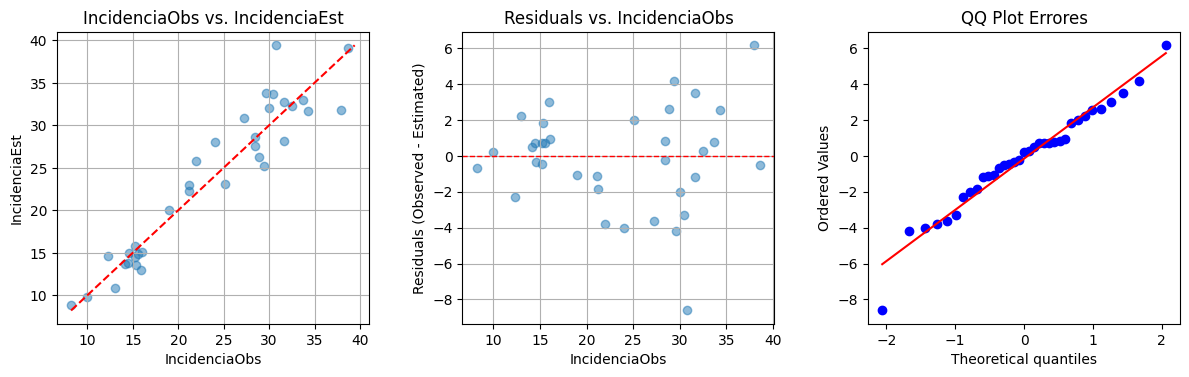

In [26]:
# RIM

aplicar_metodo(nombreMetodo='RIM', RangoEdad='RangoEdad4080',
               Ratio='RIM', transformation='Log')

0  predicciones previas de RIMH eliminadas

Escenario22
Cargando Escenario22  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  23  81 151  71  72  73  74]  N= 372
Testing:  2005 - 2014 [22]  N= 48
Modelo:  LogRIMH ~ MedianaRangoEdad4080
338 observaciones para entrenamiento,  34  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with cg

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning:

MixedLM optimization failed, trying a different optimizer may help.

/usr/local/lib/python3.12

❌ NO convergió modelo, Log-Likelihood = -163.80774837944307

---
Escenario21
Cargando Escenario21  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  22  23  81 151  71  72  73  74]  N= 372
Testing:  2005 - 2014 [21]  N= 48
Modelo:  LogRIMH ~ MedianaRangoEdad4080
334 observaciones para entrenamiento,  38  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with cg

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning:

MixedLM optimization failed, trying a different optimizer may help.

/usr/local/lib/python3.12

❌ NO convergió modelo, Log-Likelihood = -168.68122629139611

---
Escenario23
Cargando Escenario23  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  81 151  71  72  73  74]  N= 372
Testing:  2005 - 2014 [23]  N= 48
Modelo:  LogRIMH ~ MedianaRangoEdad4080
353 observaciones para entrenamiento,  19  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -172.08884601738782
48  predicciones guardadas
---
Escenario81
Cargando Escenario81  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23 151  71  72  73  74]  N= 396
Testing:  2007 - 2010 [81]  N= 24
Modelo:  LogRIMH ~ MedianaRangoEdad4080
358 observaciones para entrenamiento,  38  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -198.96363476855072
24  predicciones guardadas
---
Escenario83
Cargando Escenario83  (evaluacion)
Training:  2004 - 2018 [141 142  21  22  23  81 151  71  72  73  74]  N= 372
Testing:  2004 - 2012 [83]  N= 48
Modelo:  LogRIMH ~ MedianaRangoEdad4080
334 observaciones para entrenamiento,  38  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -188.37012190014116
48  predicciones guardadas
---
Escenario141
Cargando Escenario141  (evaluacion)
Training:  2004 - 2018 [ 83 142  21  22  23  81 151  71  72  73  74]  N= 360
Testing:  2004 - 2016 [141]  N= 60
Modelo:  LogRIMH ~ MedianaRangoEdad4080
322 observaciones para entrenamiento,  38  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -183.06924342630805
60  predicciones guardadas
---
Escenario142
Cargando Escenario142  (evaluacion)
Training:  2004 - 2018 [ 83 141  21  22  23  81 151  71  72  73  74]  N= 360
Testing:  2004 - 2016 [142]  N= 60
Modelo:  LogRIMH ~ MedianaRangoEdad4080
329 observaciones para entrenamiento,  31  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -166.75039151151623
60  predicciones guardadas
---
Escenario151
Cargando Escenario151  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81  71  72  73  74]  N= 384
Testing:  2010 - 2017 [151]  N= 36
Modelo:  LogRIMH ~ MedianaRangoEdad4080
347 observaciones para entrenamiento,  37  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -189.56536796225225
36  predicciones guardadas
---
Escenario71
Cargando Escenario71  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  72  73  74]  N= 408
Testing:  2018 - 2018 [71]  N= 12
Modelo:  LogRIMH ~ MedianaRangoEdad4080
370 observaciones para entrenamiento,  38  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with cg

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning:

MixedLM optimization failed, trying a different optimizer may help.

/usr/local/lib/python3.12

❌ NO convergió modelo, Log-Likelihood = -199.14480361396795

---
Escenario72
Cargando Escenario72  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  73  74]  N= 408
Testing:  2018 - 2018 [72]  N= 12
Modelo:  LogRIMH ~ MedianaRangoEdad4080
376 observaciones para entrenamiento,  32  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with cg

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning:

MixedLM optimization failed, trying a different optimizer may help.

/usr/local/lib/python3.12

❌ NO convergió modelo, Log-Likelihood = -195.39156637599854

---
Escenario73
Cargando Escenario73  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  74]  N= 408
Testing:  2018 - 2018 [73]  N= 12
Modelo:  LogRIMH ~ MedianaRangoEdad4080
370 observaciones para entrenamiento,  38  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -198.35371579344542
12  predicciones guardadas
---
Escenario74
Cargando Escenario74  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73]  N= 408
Testing:  2018 - 2018 [74]  N= 12
Modelo:  LogRIMH ~ MedianaRangoEdad4080
371 observaciones para entrenamiento,  37  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -195.74155937286514
12  predicciones guardadas
---
Escenario1
Cargando Escenario1  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73  74]  N= 420
Testing:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73  74]  N= 420
Modelo:  LogRIMH ~ MedianaRangoEdad4080
382 observaciones para entrenamiento,  38  ratios nulos o cero
            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   LogRIMH  
No. Observations:   382       Method:               REML     
No. Groups:         12        Scale:                0.1609   
Min. group size:    6         Log-Likelihood:       -201.4638
Max. group size:    60        Converged:            Yes      
Mean group size:    31.8                                     
-------------------------------------------------------------
                     Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------

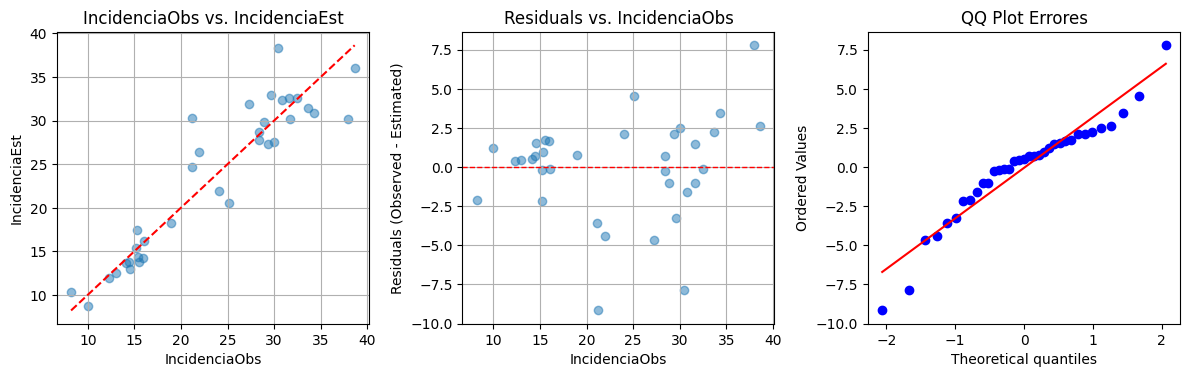

In [27]:
aplicar_metodo(nombreMetodo='RIMH', RangoEdad='RangoEdad4080', Ratio='RIMH',
               transformation='Log')

0  predicciones previas de RIH eliminadas

Escenario22
Cargando Escenario22  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  23  81 151  71  72  73  74]  N= 372
Testing:  2005 - 2014 [22]  N= 48
Modelo:  LogRIH ~ MedianaRangoEdad4080
333 observaciones para entrenamiento,  39  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -218.60189657693127
48  predicciones guardadas
---
Escenario21
Cargando Escenario21  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  22  23  81 151  71  72  73  74]  N= 372
Testing:  2005 - 2014 [21]  N= 48
Modelo:  LogRIH ~ MedianaRangoEdad4080
327 observaciones para entrenamiento,  45  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -213.92030850663332
48  predicciones guardadas
---
Escenario23
Cargando Escenario23  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  81 151  71  72  73  74]  N= 372
Testing:  2005 - 2014 [23]  N= 48
Modelo:  LogRIH ~ MedianaRangoEdad4080
349 observaciones para entrenamiento,  23  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -228.336844192449
48  predicciones guardadas
---
Escenario81
Cargando Escenario81  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23 151  71  72  73  74]  N= 396
Testing:  2007 - 2010 [81]  N= 24
Modelo:  LogRIH ~ MedianaRangoEdad4080
351 observaciones para entrenamiento,  45  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -245.18896633852546
24  predicciones guardadas
---
Escenario83
Cargando Escenario83  (evaluacion)
Training:  2004 - 2018 [141 142  21  22  23  81 151  71  72  73  74]  N= 372
Testing:  2004 - 2012 [83]  N= 48
Modelo:  LogRIH ~ MedianaRangoEdad4080
327 observaciones para entrenamiento,  45  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -224.42379677417352
48  predicciones guardadas
---
Escenario141
Cargando Escenario141  (evaluacion)
Training:  2004 - 2018 [ 83 142  21  22  23  81 151  71  72  73  74]  N= 360
Testing:  2004 - 2016 [141]  N= 60
Modelo:  LogRIH ~ MedianaRangoEdad4080
315 observaciones para entrenamiento,  45  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -228.8249568240809
60  predicciones guardadas
---
Escenario142
Cargando Escenario142  (evaluacion)
Training:  2004 - 2018 [ 83 141  21  22  23  81 151  71  72  73  74]  N= 360
Testing:  2004 - 2016 [142]  N= 60
Modelo:  LogRIH ~ MedianaRangoEdad4080
323 observaciones para entrenamiento,  37  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -201.24761825812516
60  predicciones guardadas
---
Escenario151
Cargando Escenario151  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81  71  72  73  74]  N= 384
Testing:  2010 - 2017 [151]  N= 36
Modelo:  LogRIH ~ MedianaRangoEdad4080
340 observaciones para entrenamiento,  44  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with cg

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning:

MixedLM optimization failed, trying a different optimizer may help.

/usr/local/lib/python3.12

❌ NO convergió modelo, Log-Likelihood = -234.00767671603364

---
Escenario71
Cargando Escenario71  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  72  73  74]  N= 408
Testing:  2018 - 2018 [71]  N= 12
Modelo:  LogRIH ~ MedianaRangoEdad4080
363 observaciones para entrenamiento,  45  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -247.0510054838212
12  predicciones guardadas
---
Escenario72
Cargando Escenario72  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  73  74]  N= 408
Testing:  2018 - 2018 [72]  N= 12
Modelo:  LogRIH ~ MedianaRangoEdad4080
369 observaciones para entrenamiento,  39  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -244.38222095405877
12  predicciones guardadas
---
Escenario73
Cargando Escenario73  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  74]  N= 408
Testing:  2018 - 2018 [73]  N= 12
Modelo:  LogRIH ~ MedianaRangoEdad4080
364 observaciones para entrenamiento,  44  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -246.7520959740998
12  predicciones guardadas
---
Escenario74
Cargando Escenario74  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73]  N= 408
Testing:  2018 - 2018 [74]  N= 12
Modelo:  LogRIH ~ MedianaRangoEdad4080
364 observaciones para entrenamiento,  44  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -245.03737769008944
12  predicciones guardadas
---
Escenario1
Cargando Escenario1  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73  74]  N= 420
Testing:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73  74]  N= 420
Modelo:  LogRIH ~ MedianaRangoEdad4080
375 observaciones para entrenamiento,  45  ratios nulos o cero
             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   LogRIH   
No. Observations:     375       Method:               REML     
No. Groups:           12        Scale:                0.2138   
Min. group size:      6         Log-Likelihood:       -252.1952
Max. group size:      60        Converged:            Yes      
Mean group size:      31.2                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------

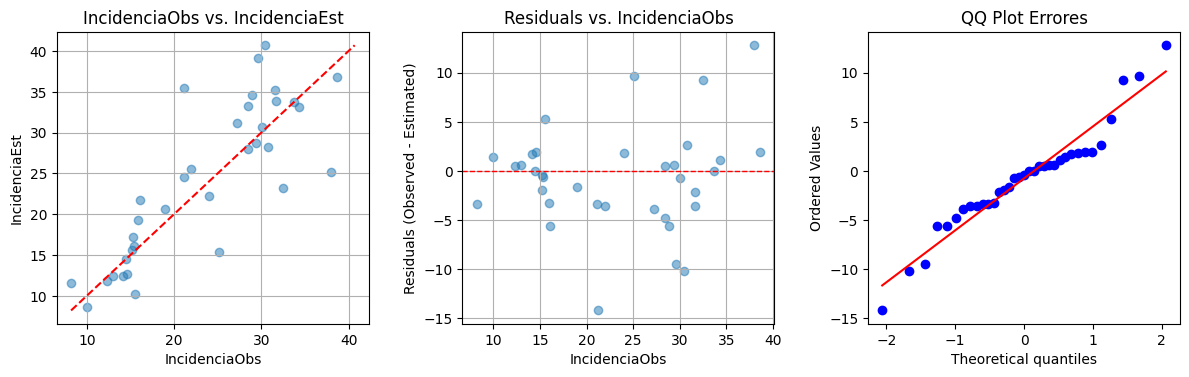

In [28]:
aplicar_metodo(nombreMetodo='RIH', RangoEdad='RangoEdad4080', Ratio='RIH',
               transformation='Log')

In [31]:
# @title Tabla 5 (internal validation)

metodos_resumen = ['RIM','RIMH','RIH']

print(resumen_errores(calcular_errores(), metodos=metodos_resumen).reindex(metodos_resumen, level='Metodo'))

                    N  IncObs  IncEst  Bias  RMSE   MAPE      R2
Evaluación Metodo                                               
Cruzada    RIM     35   23.32   23.49 -0.17  2.86   9.20  0.8851
           RIMH    25   26.69   26.76 -0.07  3.72  10.69  0.7332
           RIH     32   24.11   25.07 -0.96  5.61  17.82  0.5549
RPCs       RIM     35   23.32   23.48 -0.16  2.78   8.86  0.8919
           RIMH    35   23.32   23.37 -0.05  3.20  10.05  0.8565
           RIH     35   23.32   24.10 -0.78  5.26  16.41  0.6119


## 📊 Modelos con covariables

0  predicciones previas de RIMcovs eliminadas

Escenario22
Cargando Escenario22  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  23  81 151  71  72  73  74]  N= 372
Testing:  2005 - 2014 [22]  N= 48
Modelo:  LogRIM ~ MedianaRangoEdad4080 + PorcC
322 observaciones para entrenamiento,  50  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -142.48224259215363
48  predicciones guardadas
---
Escenario21
Cargando Escenario21  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  22  23  81 151  71  72  73  74]  N= 372
Testing:  2005 - 2014 [21]  N= 48
Modelo:  LogRIM ~ MedianaRangoEdad4080 + PorcC


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



317 observaciones para entrenamiento,  55  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -150.1533557650722
48  predicciones guardadas
---
Escenario23
Cargando Escenario23  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  81 151  71  72  73  74]  N= 372
Testing:  2005 - 2014 [23]  N= 48
Modelo:  LogRIM ~ MedianaRangoEdad4080 + PorcC
337 observaciones para entrenamiento,  35  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -153.10773379000068


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



48  predicciones guardadas
---
Escenario81
Cargando Escenario81  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23 151  71  72  73  74]  N= 396
Testing:  2007 - 2010 [81]  N= 24
Modelo:  LogRIM ~ MedianaRangoEdad4080 + PorcC
339 observaciones para entrenamiento,  57  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -172.3022729734256
24  predicciones guardadas
---
Escenario83
Cargando Escenario83  (evaluacion)
Training:  2004 - 2018 [141 142  21  22  23  81 151  71  72  73  74]  N= 372
Testing:  2004 - 2012 [83]  N= 48
Modelo:  LogRIM ~ MedianaRangoEdad4080 + PorcC
316 observaciones para entrenamiento,  56  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -167.9879539493146
48  predicciones guardadas
---
Escenario141
Cargando Escenario141  (evaluacion)
Training:  2004 - 2018 [ 83 142  21  22  23  81 151  71  72  73  74]  N= 360
Testing:  2004 - 2016 [141]  N= 60
Modelo:  LogRIM ~ MedianaRangoEdad4080 + PorcC
305 observaciones para entrenamiento,  55  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -149.79351155123993
60  predicciones guardadas
---
Escenario142
Cargando Escenario142  (evaluacion)
Training:  2004 - 2018 [ 83 141  21  22  23  81 151  71  72  73  74]  N= 360
Testing:  2004 - 2016 [142]  N= 60
Modelo:  LogRIM ~ MedianaRangoEdad4080 + PorcC
314 observaciones para entrenamiento,  46  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -146.3494892938652
60  predicciones guardadas
---
Escenario151
Cargando Escenario151  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81  71  72  73  74]  N= 384
Testing:  2010 - 2017 [151]  N= 36
Modelo:  LogRIM ~ MedianaRangoEdad4080 + PorcC
331 observaciones para entrenamiento,  53  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -157.6554313830511
36  predicciones guardadas
---
Escenario71
Cargando Escenario71  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  72  73  74]  N= 408
Testing:  2018 - 2018 [71]  N= 12
Modelo:  LogRIM ~ MedianaRangoEdad4080 + PorcC
351 observaciones para entrenamiento,  57  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -170.60187246719624
12  predicciones guardadas
---
Escenario72


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



Cargando Escenario72  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  73  74]  N= 408
Testing:  2018 - 2018 [72]  N= 12
Modelo:  LogRIM ~ MedianaRangoEdad4080 + PorcC
356 observaciones para entrenamiento,  52  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -171.39793402521286
12  predicciones guardadas
---
Escenario73
Cargando Escenario73  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  74]  N= 408
Testing:  2018 - 2018 [73]  N= 12
Modelo:  LogRIM ~ MedianaRangoEdad4080 + PorcC
351 observaciones para entrenamiento,  57  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -170.65039629547368
12  predicciones guardadas
---
Escenario74
Cargando Escenario74  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73]  N= 408
Testing:  2018 - 2018 [74]  N= 12
Modelo:  LogRIM ~ MedianaRangoEdad4080 + PorcC
354 observaciones para entrenamiento,  54  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -171.83776190309504


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



12  predicciones guardadas
---
Escenario1
Cargando Escenario1  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73  74]  N= 420
Testing:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73  74]  N= 420
Modelo:  LogRIM ~ MedianaRangoEdad4080 + PorcC
363 observaciones para entrenamiento,  57  ratios nulos o cero
             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    LogRIM   
No. Observations:    363        Method:                REML     
No. Groups:          12         Scale:                 0.1436   
Min. group size:     7          Log-Likelihood:        -174.4686
Max. group size:     58         Converged:             Yes      
Mean group size:     30.2                                       
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept        

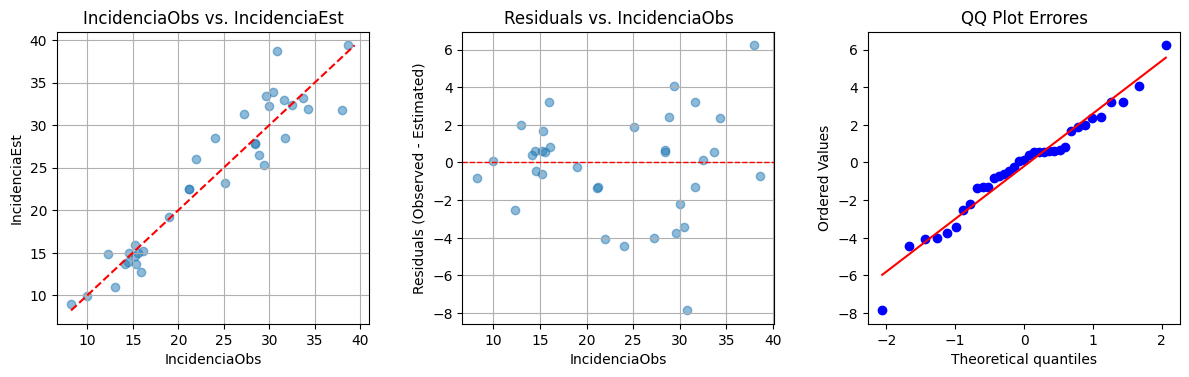

In [32]:
# RIM  + covariables

aplicar_metodo(nombreMetodo='RIMcovs', RangoEdad='RangoEdad4080', Ratio='RIM',
               transformation='Log', covariables=['PorcC'])

0  predicciones previas de RIMHcovs eliminadas

Escenario22
Cargando Escenario22  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  23  81 151  71  72  73  74]  N= 372
Testing:  2005 - 2014 [22]  N= 48
Modelo:  LogRIMH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
338 observaciones para entrenamiento,  34  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -163.5177665994164
48  predicciones guardadas
---
Escenario21
Cargando Escenario21  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  22  23  81 151  71  72  73  74]  N= 372
Testing:  2005 - 2014 [21]  N= 48
Modelo:  LogRIMH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
334 observaciones para entrenamiento,  38  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -165.37640254035261
48  predicciones guardadas
---
Escenario23
Cargando Escenario23  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  81 151  71  72  73  74]  N= 372
Testing:  2005 - 2014 [23]  N= 48
Modelo:  LogRIMH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
353 observaciones para entrenamiento,  19  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -168.98288464617076
48  predicciones guardadas
---
Escenario81
Cargando Escenario81  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23 151  71  72  73  74]  N= 396
Testing:  2007 - 2010 [81]  N= 24
Modelo:  Lo

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



24  predicciones guardadas
---
Escenario83
Cargando Escenario83  (evaluacion)
Training:  2004 - 2018 [141 142  21  22  23  81 151  71  72  73  74]  N= 372
Testing:  2004 - 2012 [83]  N= 48
Modelo:  LogRIMH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
334 observaciones para entrenamiento,  38  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -185.58358881742788
48  predicciones guardadas
---
Escenario141
Cargando Escenario141  (evaluacion)
Training:  2004 - 2018 [ 83 142  21  22  23  81 151  71  72  73  74]  N= 360
Testing:  2004 - 2016 [141]  N= 60
Modelo:  LogRIMH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
322 observaciones para entrenamiento,  38  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -182.64749152409922
60  predicciones guardadas
---
Escenario142
Cargando Escenario142  (evaluacion)
Training:  2004 - 2018 [ 83 141  21  22  23  81 151  71  72  73  74]  N= 360
Testing:  2004 - 2016 [142]  N= 60
Modelo:  LogRIMH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
329 observaciones para entrenamiento,  31  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -168.75769235389748
60  predicciones guardadas
---
Escenario151
Cargando Escenario151  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81  71  72  73  74]  N= 384
Testing:  2010 - 2017 [151]  N= 36
Modelo:  LogRIMH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
347 observaciones para entrenamiento,  37  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with cg

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-package

❌ NO convergió modelo, Log-Likelihood = -186.7194541010722

---
Escenario71
Cargando Escenario71  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  72  73  74]  N= 408
Testing:  2018 - 2018 [71]  N= 12
Modelo:  LogRIMH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
370 observaciones para entrenamiento,  38  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -195.54577900138497
12  predicciones guardadas
---
Escenario72
Cargando Escenario72  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  73  74]  N= 408
Testing:  2018 - 2018 [72]  N= 12
Modelo:  LogRIMH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
376 observaciones para entrenamiento,  32  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -193.31207403444841
12  predicciones guardadas
---
Escenario73
Cargando Escenario73  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  74]  N= 408
Testing:  2018 - 2018 [73]  N= 12
Modelo:  LogRIMH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
370 observaciones para entrenamiento,  38  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -194.46829415206344
12  predicciones guardadas
---
Escenario74
Cargando Escenario74  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73]  N= 408
Testing:  2018 - 2018 [74]  N= 12
Modelo:  LogRIMH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
371 observaciones para entrenamiento,  37  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -192.31463914672622
12  predicciones guardadas
---
Escenario1
Cargando Escenario1  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73  74]  N= 420
Testing:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73  74]  N= 420
Modelo:  LogRIMH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
382 observaciones para entrenamiento,  38  ratios nulos o cero
             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   LogRIMH  
No. Observations:     382       Method:               REML     
No. Groups:           12        Scale:                0.1534   
Min. group size:      6         Log-Likelihood:       -198.9950
Max. group size:      60        Converged:            Yes      
Mean group size:      31.8                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------

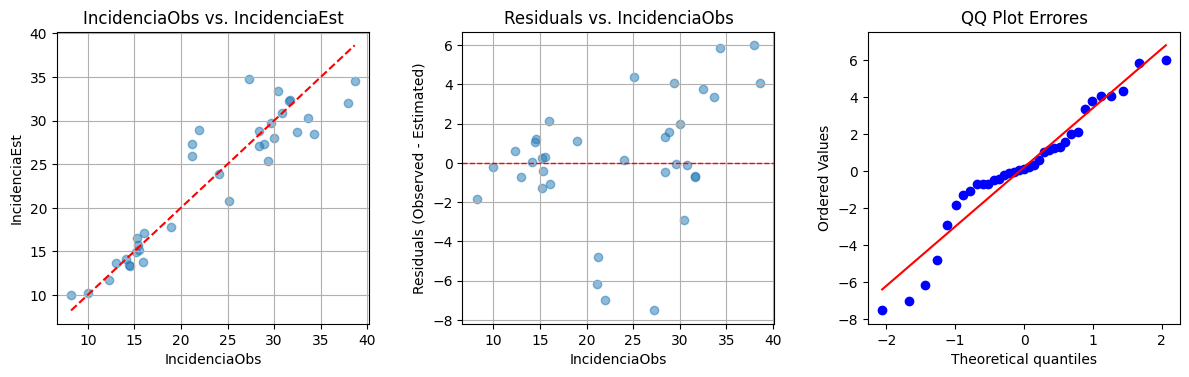

In [33]:
aplicar_metodo(nombreMetodo='RIMHcovs', RangoEdad='RangoEdad4080', Ratio='RIMH',
               transformation='Log', covariables=['Periodo','PorcIsapre'])

0  predicciones previas de RIHcovs eliminadas

Escenario22
Cargando Escenario22  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  23  81 151  71  72  73  74]  N= 372
Testing:  2005 - 2014 [22]  N= 48
Modelo:  LogRIH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
333 observaciones para entrenamiento,  39  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -217.52114589256576
48  predicciones guardadas
---
Escenario21
Cargando Escenario21  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  22  23  81 151  71  72  73  74]  N= 372
Testing:  2005 - 2014 [21]  N= 48
Modelo:  LogRIH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
327 observaciones para entrenamiento,  45  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -213.01474856826871
48  predicciones guardadas
---
Escenario23
Cargando Escenario23  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  81 151  71  72  73  74]  N= 372
Testing:  2005 - 2014 [23]  N= 48
Modelo:  LogRIH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
349 observaciones para entrenamiento,  23  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -223.1114263482831
48  predicciones guardadas
---
Escenario81
Cargando Escenario81  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23 151  71  72  73  74]  N= 396
Testing:  2007 - 2010 [81]  N= 24
Modelo:  LogRIH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
351 observaciones para entrenamiento,  45  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -241.15137535631357
24  predicciones guardadas
---
Escenario83
Cargando Escenario83  (evaluacion)
Training:  2004 - 2018 [141 142  21  22  23  81 151  71  72  73  74]  N= 372
Testing:  2004 - 2012 [83]  N= 48
Modelo:  LogRIH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
327 observaciones para entrenamiento,  45  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -216.32445653504078
48  predicciones guardadas
---
Escenario141
Cargando Escenario141  (evaluacion)
Training:  2004 - 2018 [ 83 142  21  22  23  81 151  71  72  73  74]  N= 360
Testing:  2004 - 2016 [141]  N= 60
Modelo:  LogRIH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
315 observaciones para entrenamiento,  45  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -227.40202577882621
60  predicciones guardadas
---
Escenario142
Cargando Escenario142  (evaluacion)
Training:  2004 - 2018 [ 83 141  21  22  23  81 151  71  72  73  74]  N= 360
Testing:  2004 - 2016 [142]  N= 60
Modelo:  LogRIH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
323 observaciones para entrenamiento,  37  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -203.87548284748573
60  predicciones guardadas
---
Escenario151
Cargando Escenario151  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81  71  72  73  74]  N= 384
Testing:  2010 - 2017 [151]  N= 36
Modelo:  LogRIH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
340 observaciones para entrenamiento,  44  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with cg

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning:

MixedLM optimization failed, trying a different optimizer may help.

/usr/local/lib/python3.12

❌ NO convergió modelo, Log-Likelihood = -228.99310184688864

---
Escenario71
Cargando Escenario71  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  72  73  74]  N= 408
Testing:  2018 - 2018 [71]  N= 12
Modelo:  LogRIH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
363 observaciones para entrenamiento,  45  ratios nulos o cero
✔ convergió modelo, Log-Likelihood = -242.80813848208595
12  predicciones guardadas
---
Escenario72
Cargando Escenario72  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  73  74]  N= 408
Testing:  2018 - 2018 [72]  N= 12
Modelo:  LogRIH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
369 observaciones para entrenamiento,  39  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -241.59043444719214
12  predicciones guardadas
---
Escenario73
Cargando Escenario73  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  74]  N= 408
Testing:  2018 - 2018 [73]  N= 12
Modelo:  LogRIH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
364 observaciones para entrenamiento,  44  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -242.11248168772568
12  predicciones guardadas
---
Escenario74
Cargando Escenario74  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73]  N= 408
Testing:  2018 - 2018 [74]  N= 12
Modelo:  LogRIH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
364 observaciones para entrenamiento,  44  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



✔ convergió modelo, Log-Likelihood = -240.8575181264698
12  predicciones guardadas
---
Escenario1
Cargando Escenario1  (evaluacion)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73  74]  N= 420
Testing:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73  74]  N= 420
Modelo:  LogRIH ~ MedianaRangoEdad4080 + Periodo + PorcIsapre
375 observaciones para entrenamiento,  45  ratios nulos o cero


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   LogRIH   
No. Observations:     375       Method:               REML     
No. Groups:           12        Scale:                0.2038   
Min. group size:      6         Log-Likelihood:       -248.7160
Max. group size:      60        Converged:            Yes      
Mean group size:      31.2                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            44.470   13.122  3.389 0.001 18.752 70.188
MedianaRangoEdad4080 -0.012    0.001 -8.896 0.000 -0.014 -0.009
Periodo              -0.022    0.007 -3.351 0.001 -0.035 -0.009
PorcIsapre           -0.525    0.250 -2.099 0.036 -1.015 -0.035
Provincia Var         0.006    0.016                           

420  predicciones guardadas
---
                    

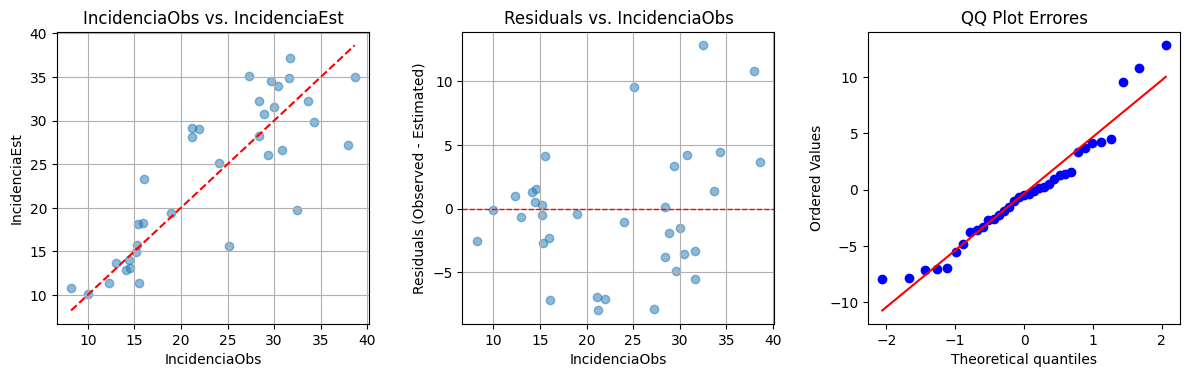

In [34]:
aplicar_metodo(nombreMetodo='RIHcovs', RangoEdad='RangoEdad4080', Ratio='RIH',
               transformation='Log', covariables=['Periodo','PorcIsapre'])

In [36]:
#@title Material Sup 9a (internal validation)
print(resumen_errores(calcular_errores(), metodos=['RIMcovs','RIMHcovs','RIHcovs']).reindex(['RIMcovs','RIMHcovs','RIHcovs'], level='Metodo'))

                      N  IncObs  IncEst  Bias  RMSE   MAPE      R2
Evaluación Metodo                                                 
Cruzada    RIMcovs   35   23.32   23.52 -0.20  2.80   8.96  0.8904
           RIMHcovs  32   24.11   23.99  0.12  3.79  11.32  0.7966
           RIHcovs   32   24.11   24.49 -0.38  5.74  17.95  0.5326
RPCs       RIMcovs   35   23.32   23.52 -0.20  2.72   8.65  0.8963
           RIMHcovs  35   23.32   23.10  0.21  3.15   9.48  0.8609
           RIHcovs   35   23.32   23.68 -0.37  4.93  15.84  0.6590


# 📈 Estimaciones Chile
Estimar incidencia para todas las provincias de Chile en el periodo 2003-2024

In [38]:
def proyectar_incidencia_Chile(nombreMetodo, RangoEdad='RangoEdad4080', Ratio='RIM', **kwargs):

  data = cargar_datos_escenario('Chile', RangoEdad, **kwargs)
  data = regresion_ratios(data, RangoEdad, Ratio, summary=True, **kwargs)
  data = proyectar_incidencia(data, Ratio, plot=True, **kwargs)
  guardar_proyecciones(data, RangoEdad, nombreMetodo)


In [39]:
# RIM
proyectar_incidencia_Chile(nombreMetodo='RIMcl', RangoEdad='RangoEdad4080',
                           Ratio='RIM', transformation='Log')

Cargando Chile  (proyección)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73  74]  N= 420
Testing:  2004 - 2023 [ 11  14  21  22  23  31  32  33  41  42  43  51  52  53  54  55  56  57
  58  61  62  63  71  72  73  74  81  82  83  91  92 101 102 103 104 111
 112 113 114 121 123 124 131 132 133 134 135 136 141 142 151 152 161 162
 163]  N= 4620
Modelo:  LogRIM ~ MedianaRangoEdad4080
363 observaciones para entrenamiento,  57  ratios nulos o cero
             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    LogRIM   
No. Observations:    363        Method:                REML     
No. Groups:          12         Scale:                 0.1449   
Min. group size:     7          Log-Likelihood:        -174.6766
Max. group size:     58         Converged:             Yes      
Mean group size:     30.2                                       
----------------------------------------------------------------
                     Coef.

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



In [40]:
# RIMH
proyectar_incidencia_Chile(nombreMetodo='RIMHcl', RangoEdad='RangoEdad4080',
                           Ratio='RIMH', transformation='Log')

Cargando Chile  (proyección)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73  74]  N= 420
Testing:  2004 - 2023 [ 11  14  21  22  23  31  32  33  41  42  43  51  52  53  54  55  56  57
  58  61  62  63  71  72  73  74  81  82  83  91  92 101 102 103 104 111
 112 113 114 121 123 124 131 132 133 134 135 136 141 142 151 152 161 162
 163]  N= 4620
Modelo:  LogRIMH ~ MedianaRangoEdad4080
382 observaciones para entrenamiento,  38  ratios nulos o cero
            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   LogRIMH  
No. Observations:   382       Method:               REML     
No. Groups:         12        Scale:                0.1609   
Min. group size:    6         Log-Likelihood:       -201.4638
Max. group size:    60        Converged:            Yes      
Mean group size:    31.8                                     
-------------------------------------------------------------
                     Coef. Std.Err.   z   P>|z|

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



In [41]:
# RIH
proyectar_incidencia_Chile(nombreMetodo='RIHcl', RangoEdad='RangoEdad4080',
                           Ratio='RIH', transformation='Log')

Cargando Chile  (proyección)
Training:  2004 - 2018 [ 83 141 142  21  22  23  81 151  71  72  73  74]  N= 420
Testing:  2004 - 2023 [ 11  14  21  22  23  31  32  33  41  42  43  51  52  53  54  55  56  57
  58  61  62  63  71  72  73  74  81  82  83  91  92 101 102 103 104 111
 112 113 114 121 123 124 131 132 133 134 135 136 141 142 151 152 161 162
 163]  N= 4620
Modelo:  LogRIH ~ MedianaRangoEdad4080
375 observaciones para entrenamiento,  45  ratios nulos o cero
             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   LogRIH   
No. Observations:     375       Method:               REML     
No. Groups:           12        Scale:                0.2138   
Min. group size:      6         Log-Likelihood:       -252.1952
Max. group size:      60        Converged:            Yes      
Mean group size:      31.2                                     
---------------------------------------------------------------
                     Coef.  Std.E

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



# 📉Comparación IARC 2003-2022

In [76]:
#@title Cargar Estimaciones Chile

def calcular_incidencia_provincias(niveles=None):

  # cargar estimaciones Chile
  predicciones = (pd.read_parquet(path_output + 'Predicciones.parquet').
                  query('Escenario=="Chile" & Grupo=="Testing"'))

  # calcular casos
  predicciones['Casos'] = predicciones.IncidenciaEst * predicciones.Poblacion / HABS
  # agregar casos al nivel definido
  niveles += ['Periodo']
  predicciones = (predicciones.groupby(niveles)[['Casos','Poblacion']].sum())
  # calcular incidencia
  predicciones['IncidenciaEst'] = predicciones.Casos / predicciones.Poblacion * HABS
  return predicciones.reset_index()

calcular_incidencia_provincias(niveles=['Metodo','Sexo']).\
pivot(index='Periodo', columns=['Metodo','Sexo'], values='IncidenciaEst').tail(5)

Metodo       RIHcl             RIHcovscl                RIMHcl             \
Sexo        Hombre      Mujer     Hombre      Mujer     Hombre      Mujer   
Periodo                                                                     
2011     30.582064  15.330707  30.639649  15.240368  29.799734  15.440143   
2014     29.851886  15.087834  32.158598  16.130507  28.747110  15.139869   
2017     29.594901  14.823891  34.157078  16.956717  28.204459  14.500450   
2020     25.915238  13.051292  31.913820  15.954626  25.057607  13.130256   
2023     27.043442  13.947018  35.434614  18.128948  25.304565  13.593270   

Metodo  RIMHcovscl                 RIMcl             RIMcovscl             
Sexo        Hombre      Mujer     Hombre      Mujer     Hombre      Mujer  
Periodo                                                                    
2011     29.965058  15.391507  31.331396  15.015181  31.393570  14.941112  
2014     30.592566  15.971114  29.899686  14.401344  29.907274  14.307584  
2017     31.623430  16.117596  28.380945  13.448858  28.639626  13.624042  
2020     29.501243  15.338971  25.574901  12.325377  25.785554  12.500559  
2023     31.174833  16.618928  24.394088  12.027766  24.563598  12.185214

In [92]:
# Cargar datos para comparar incidencia estimada vs iarc (por año y sexo)

def data_comparacion_incidencias_nac(pobEstandar=True, periodo=range(2003,2018), metodos=None, **kwargs):

  # Obtener incidencia cruda por sexo-método
  inc = calcular_incidencia_provincias(niveles=['Metodo','Sexo','RangoEdad4080'])
  # Filtrar periodo y métodos
  inc = inc[inc.Metodo.isin(metodos) & inc.Periodo.isin(periodo)]
  # Calcular incidencia ambos sexos
  ambos = inc.groupby(['Metodo','Periodo','RangoEdad4080'])[['Casos','Poblacion']].sum().reset_index()
  ambos['IncidenciaEst'] = ambos.Casos / ambos.Poblacion * HABS
  ambos.insert(0,'Sexo','Ambos')
  inc = pd.concat([inc, ambos]).reset_index(drop=False)

  # calcular incidencia estandarizada
  inc = inc.merge(poblacion_estandar, on='RangoEdad4080', how='left')
  # calcular casos en poblacion OMS
  inc['Casos'] = inc.IncidenciaEst * inc.PoblacionOMS / HABS
  inc = inc.groupby(['Metodo','Periodo','Sexo'])[['Casos','PoblacionOMS']].sum().reset_index()
  # calcular incidencia en poblacion OMS
  inc['IncidenciaEst'] = inc.Casos / inc.PoblacionOMS * HABS

  # Agregar estimación IARC por sexo-año
  inc = (inc.merge(incidenciaIARC,how='left',on=['Periodo','Sexo'])
         [['Metodo','Sexo','Año','Periodo','IncidenciaEst','IncidenciaIARC']])

  return inc

incEstIARC = data_comparacion_incidencias_nac(Grupo='Testing', pobEstandar=True,
                                              metodos=['RIMcl','RIMHcl','RIHcl',
                                                       'RIMcovscl','RIMHcovscl','RIHcovscl'],
                                              periodo=range(2003,2025))
incEstIARC

,Metodo,Sexo,Año,Periodo,IncidenciaEst,IncidenciaIARC
0,RIHcl,Ambos,2003.0,2004,24.162043,26.424614
1,RIHcl,Ambos,2004.0,2004,24.162043,25.425949
2,RIHcl,Ambos,2005.0,2004,24.162043,20.079171
3,RIHcl,Hombre,2003.0,2004,36.106136,40.615410
4,RIHcl,Hombre,2004.0,2004,36.106136,38.216309
...,...,...,...,...,...,...
301,RIMcovscl,Hombre,NaN,2020,20.510827,NaN
302,RIMcovscl,Mujer,NaN,2020,8.039759,NaN
303,RIMcovscl,Ambos,2022.0,2023,12.082776,14.200000
304,RIMcovscl,Hombre,2022.0,2023,17.982675,21.800000


In [93]:
print('Reducción periodos 2004-2023:',
      incEstIARC[lambda x: ((x.Metodo=='RIMcl') & (x.Sexo=='Ambos') & (x.Periodo.isin([2004,2023])))][['Periodo','IncidenciaEst']].drop_duplicates().set_index('Periodo').apply(lambda x: x.loc[2023]/x.loc[2004]*100))

incEstIARC[lambda x: ((x.Metodo=='RIMcl') & (x.Sexo=='Ambos'))].groupby('Periodo')[['IncidenciaEst','IncidenciaIARC']].mean().round(1).T

Reducción periodos 2004-2023: IncidenciaEst    51.822175
dtype: float64


Periodo,2004,2007,2011,2014,2017,2020,2023
IncidenciaEst,23.2,20.9,19.9,17.6,15.5,13.4,12.0
IncidenciaIARC,24.0,22.8,22.3,20.6,20.8,NaN,14.2


In [95]:
#@title Tabla 5 (external validation)

def tabla5(df, metodos):
  print('\nIncidencia 2003-2022 promedio estimada vs IARC')

  df = (df[df.Metodo.isin(metodos) & df.IncidenciaIARC.notna()].
        groupby(['Metodo','Sexo'])[['IncidenciaEst','IncidenciaIARC']].mean().reset_index())
  df['Ratio'] = df.Metodo.str[:-2] #quitar 'cl'
  df['Bias'] = df.IncidenciaIARC.astype(float) - df.IncidenciaEst.astype(float)

  # Cambiar estructura tabla
  df = (df[['Ratio','Sexo','IncidenciaEst','IncidenciaIARC','Bias']].round(2).
        melt(id_vars=['Ratio','Sexo'],
             value_vars=['IncidenciaEst','IncidenciaIARC','Bias'],
             var_name='Metric',
             value_name='Value').reset_index().
        pivot(index=['Metric','Sexo'], columns=['Ratio'], values='Value'))

  return df

tabla5(incEstIARC.copy(), ['RIMcl','RIMHcl','RIHcl'])


Incidencia 2003-2022 promedio estimada vs IARC


Ratio                    RIH    RIM   RIMH
Metric         Sexo                       
Bias           Ambos    1.76   2.47   2.01
               Hombre   2.71   2.79   3.10
               Mujer    0.20   1.40   0.29
IncidenciaEst  Ambos   19.93  19.22  19.69
               Hombre  29.86  29.79  29.47
               Mujer   12.28  11.09  12.19
IncidenciaIARC Ambos   21.69  21.69  21.69
               Hombre  32.57  32.57  32.57
               Mujer   12.48  12.48  12.48

In [96]:
# Métodos con covariables
#@title Material Sup 9a (external validation)

tabla5(incEstIARC.copy(), ['RIMcovscl','RIMHcovscl','RIHcovscl'])


Incidencia 2003-2022 promedio estimada vs IARC


Ratio                  RIHcovs  RIMHcovs  RIMcovs
Metric         Sexo                              
Bias           Ambos      1.95      2.15     2.45
               Hombre     2.94      3.26     2.71
               Mujer      0.38      0.45     1.42
IncidenciaEst  Ambos     19.74     19.54    19.24
               Hombre    29.63     29.32    29.87
               Mujer     12.10     12.03    11.06
IncidenciaIARC Ambos     21.69     21.69    21.69
               Hombre    32.57     32.57    32.57
               Mujer     12.48     12.48    12.48

In [99]:
#@title Series de tiempo IncidenciaEst vs IARC

def plot_incidencia_iarc(data, poblacionEstandar=True):
  # Determine the column for IARC data
  iarc_col = 'IncidenciaIARC' if poblacionEstandar else 'IncidenciaCruda'

  unique_sexes = data['Sexo'].unique()
  num_cols = len(unique_sexes)

  # Create subplots
  fig, axes = plt.subplots(1, num_cols, figsize=(num_cols * 6, 4), sharey=True)
  if num_cols == 1: # Ensure axes is always iterable
        axes = [axes]

  # Assign distinct colors for each sex
  sex_colors = sns.color_palette('tab10', n_colors=num_cols)
  sex_color_map = dict(zip(unique_sexes, sex_colors))

  # Add traces for each sex
  for i, sex in enumerate(unique_sexes):
      ax = axes[i]
      sex_data = data[data['Sexo'] == sex].copy() # Make a copy to avoid SettingWithCopyWarning
      sex_data["Año"] = sex_data["Año"].astype('Int64') # Convert Año to integer for integer labels

      current_color = sex_color_map.get(sex, 'gray')

      # Plot IncidenciaEst as a line
      sns.lineplot(x=sex_data["Año"], y=sex_data["IncidenciaEst"], ax=ax, label=f'Modelo ({sex})', color=current_color, linestyle='-')

      # Plot IARC data as markers
      sns.scatterplot(x=sex_data["Año"], y=sex_data[iarc_col], ax=ax, label=f'IARC ({sex})', color=current_color, marker='o', s=50)

      ax.set_title(f'Sexo: {sex}')
      ax.set_xlabel('Año')
      ax.set_ylabel('Incidencia' if i == 0 else '')
      ax.legend(title='Fuente', loc='upper right')
      ax.grid(True, linestyle='--', alpha=0.7)

      # Ensure x-axis labels are integers
      ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

  fig.suptitle(f'Incidencia por sexo ({data.Metodo.iloc[0]})', y=1.02, fontsize=16)
  plt.tight_layout(rect=[0, 0, 1, 0.98])
  plt.show()

def regresion_incidencias_comparadas(data, metodo, sexo='Hombre'):

  # cargar datos
  data = data[(data.Sexo==sexo)&(data.Año.isin(range(2003,2025)))]
  data = data.melt(id_vars=['Sexo','Año'], var_name='Estimacion', value_name='Incidencia', value_vars=['IncidenciaEst','IncidenciaIARC'])

  # transformar variables
  data.loc[data.Estimacion=='IncidenciaEst','Estimacion'] = 'Modelo'
  data.loc[data.Estimacion=='IncidenciaIARC','Estimacion'] = 'IARC'

  # fit linear regression model Incidencia ~ Año + Estimacion
  y = data['Incidencia'].astype(float)
  X = sm.add_constant((data['Año']-data['Año'].min()).astype(int))
  X = pd.concat([X, pd.get_dummies(data['Estimacion']).drop(columns='Modelo')], axis=1).astype(int) # Convert to float after getting dummies
  model = sm.regression.linear_model.GLS(y, X).fit()
  print(f'Diferencia IARC-modelo serie {sexo}: {model.params.IARC.round(2)} (p-valor {model.pvalues.IARC.round(3)})')
#  print(model.summary())

def comparar_series(metodo):
    df = incEstIARC[incEstIARC.Metodo==metodo].copy()
    print(metodo+'\n', df.pivot_table(index='Sexo',values=['IncidenciaEst','IncidenciaIARC'],aggfunc='mean'))
    regresion_incidencias_comparadas(df, metodo, sexo='Ambos')
    regresion_incidencias_comparadas(df, metodo, sexo='Hombre')
    regresion_incidencias_comparadas(df, metodo, sexo='Mujer')
    plot_incidencia_iarc(df)


Fit a Generalized Least Squares (GLS) linear regression model:

$ \text{Incidencia} = \beta_0 + \beta_1 (\text{Año} - \text{min(Año)}) + \beta_2 \text{Estimacion}_{\text{IARC}} + \epsilon $

Where:

- $  $$ \text{Incidencia} $ is the dependent variable (the value from the 'Incidencia' column).
- $ \beta_0 $ is the intercept.
- $ \beta_1 $ is the coefficient for the centered 'Año' variable.
- $ (\text{Año} - \text{min(Año)}) $$ (\text{Año} - \text{min(Año)}) $ is the centered year variable.
- $ \beta_2 $$ \beta_2 $ is the coefficient for the 'Estimacion' being 'IARC'.
- $ \text{Estimacion}_{\text{IARC}} $ is a dummy variable that is 1 if the estimation is 'IARC' and 0 if it is 'Modelo' (the reference category).
- $ \epsilon $ is the error term, which in GLS can have a non-diagonal covariance matrix to account for heteroscedasticity or autocorrelation.

The model estimates how 'Incidencia' changes with the year and whether the estimation method is 'IARC' compared to 'Modelo'. The difference in incidence between 'IARC' and 'Modelo', after accounting for the effect of the year, is represented by the coefficient $ \beta_2 $.

RIMcl
         IncidenciaEst  IncidenciaIARC
Sexo                                 
Ambos       18.883309       21.694851
Hombre      29.230519       32.574238
Mujer       10.900723       12.481371
Diferencia IARC-modelo serie Ambos: 2.47 (p-valor 0.0)
Diferencia IARC-modelo serie Hombre: 2.79 (p-valor 0.018)
Diferencia IARC-modelo serie Mujer: 1.4 (p-valor 0.0)


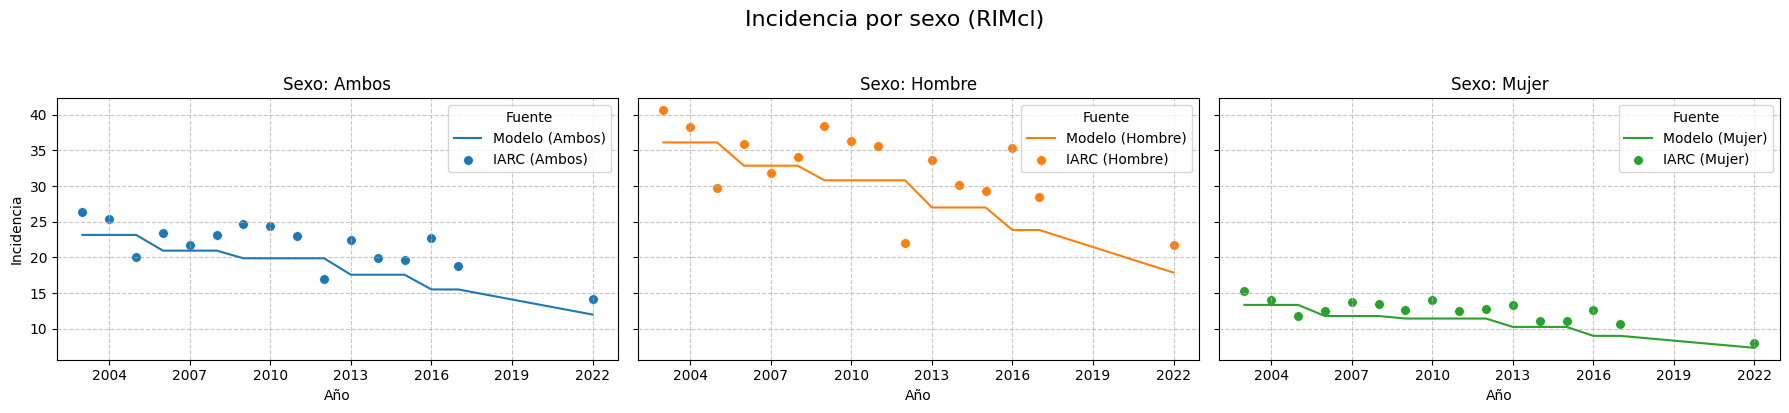

In [100]:
comparar_series('RIMcl')

RIMHcl
         IncidenciaEst  IncidenciaIARC
Sexo                                 
Ambos       19.333251       21.694851
Hombre      28.910007       32.574238
Mujer       11.980032       12.481371
Diferencia IARC-modelo serie Ambos: 2.01 (p-valor 0.003)
Diferencia IARC-modelo serie Hombre: 3.1 (p-valor 0.01)
Diferencia IARC-modelo serie Mujer: 0.29 (p-valor 0.375)


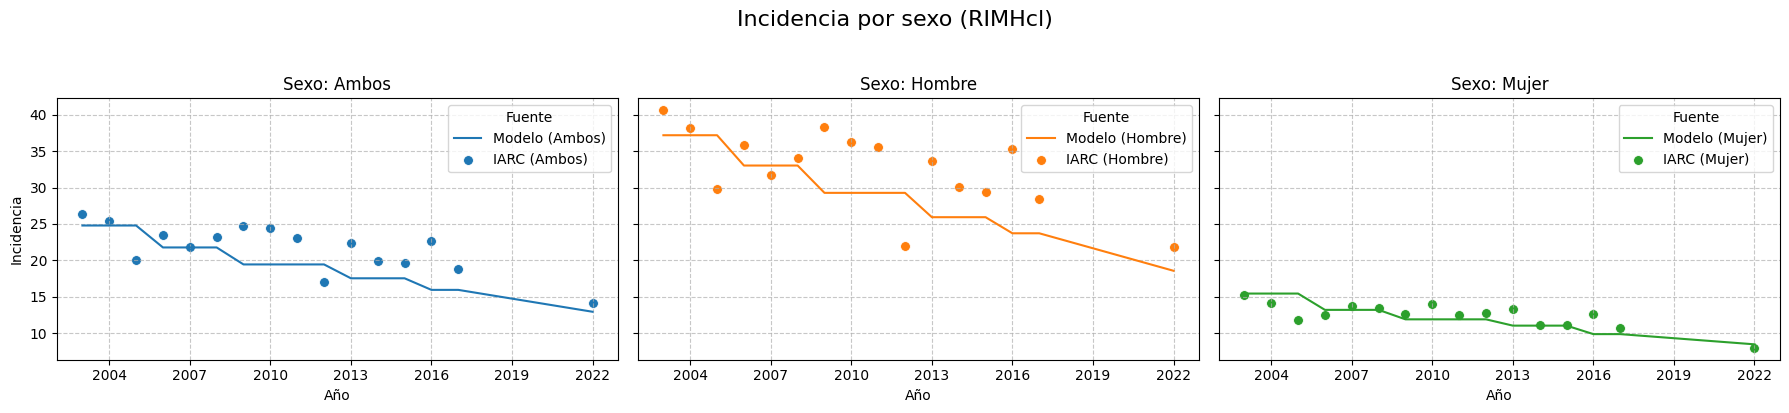

In [101]:
comparar_series('RIMHcl')

RIHcl
         IncidenciaEst  IncidenciaIARC
Sexo                                 
Ambos       19.587202       21.694851
Hombre      29.317930       32.574238
Mujer       12.074690       12.481371
Diferencia IARC-modelo serie Ambos: 1.76 (p-valor 0.005)
Diferencia IARC-modelo serie Hombre: 2.71 (p-valor 0.019)
Diferencia IARC-modelo serie Mujer: 0.2 (p-valor 0.509)


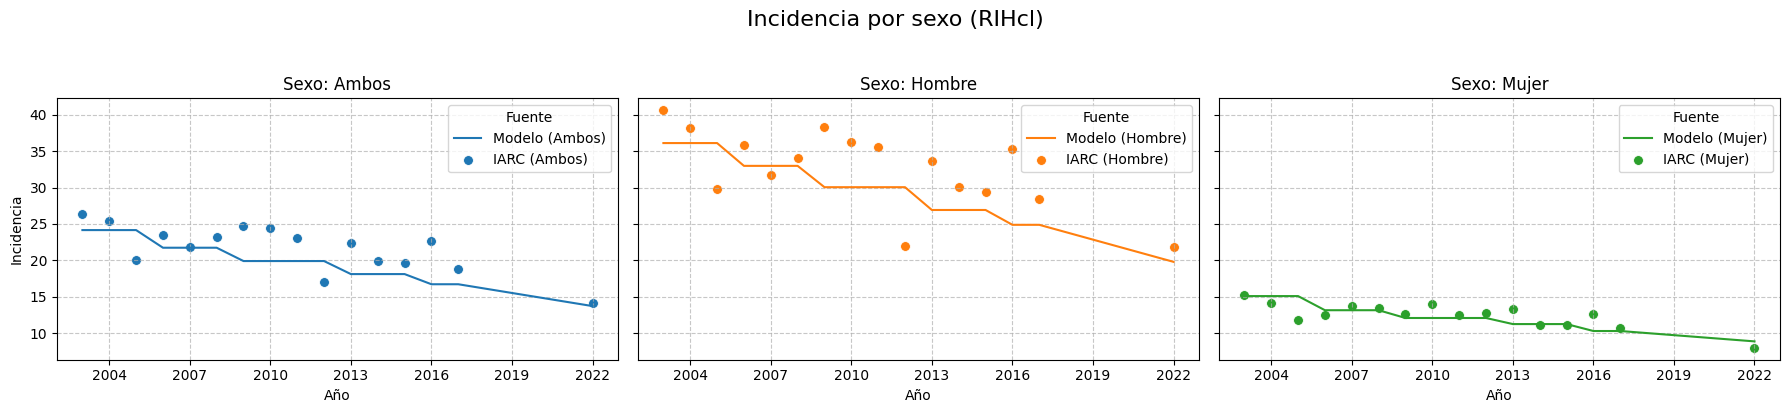

In [102]:
comparar_series('RIHcl')